In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("cloudburst.csv")
pd.set_option("display.max_columns", None)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Almora,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Almora,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Almora,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Almora,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Almora,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
df.isnull().sum()*100/len(df)

Date                   0.000000
Location               0.000000
MinTemp                1.020899
MaxTemp                0.866905
Rainfall               2.241853
Evaporation           43.166506
Sunshine              48.009762
WindGustDir            7.098859
WindGustSpeed          7.055548
WindDir9am             7.263853
WindDir3pm             2.906641
WindSpeed9am           1.214767
WindSpeed3pm           2.105046
Humidity9am            1.824557
Humidity3pm            3.098446
Pressure9am           10.356799
Pressure3pm           10.331363
Cloud9am              38.421559
Cloud3pm              40.807095
Temp9am                1.214767
Temp3pm                2.481094
CloudBurst Today       2.241853
CloudBurstTomorrow     2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [7]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [8]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Almora,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,02-12-2008,Almora,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,03-12-2008,Almora,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,04-12-2008,Almora,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,05-12-2008,Almora,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


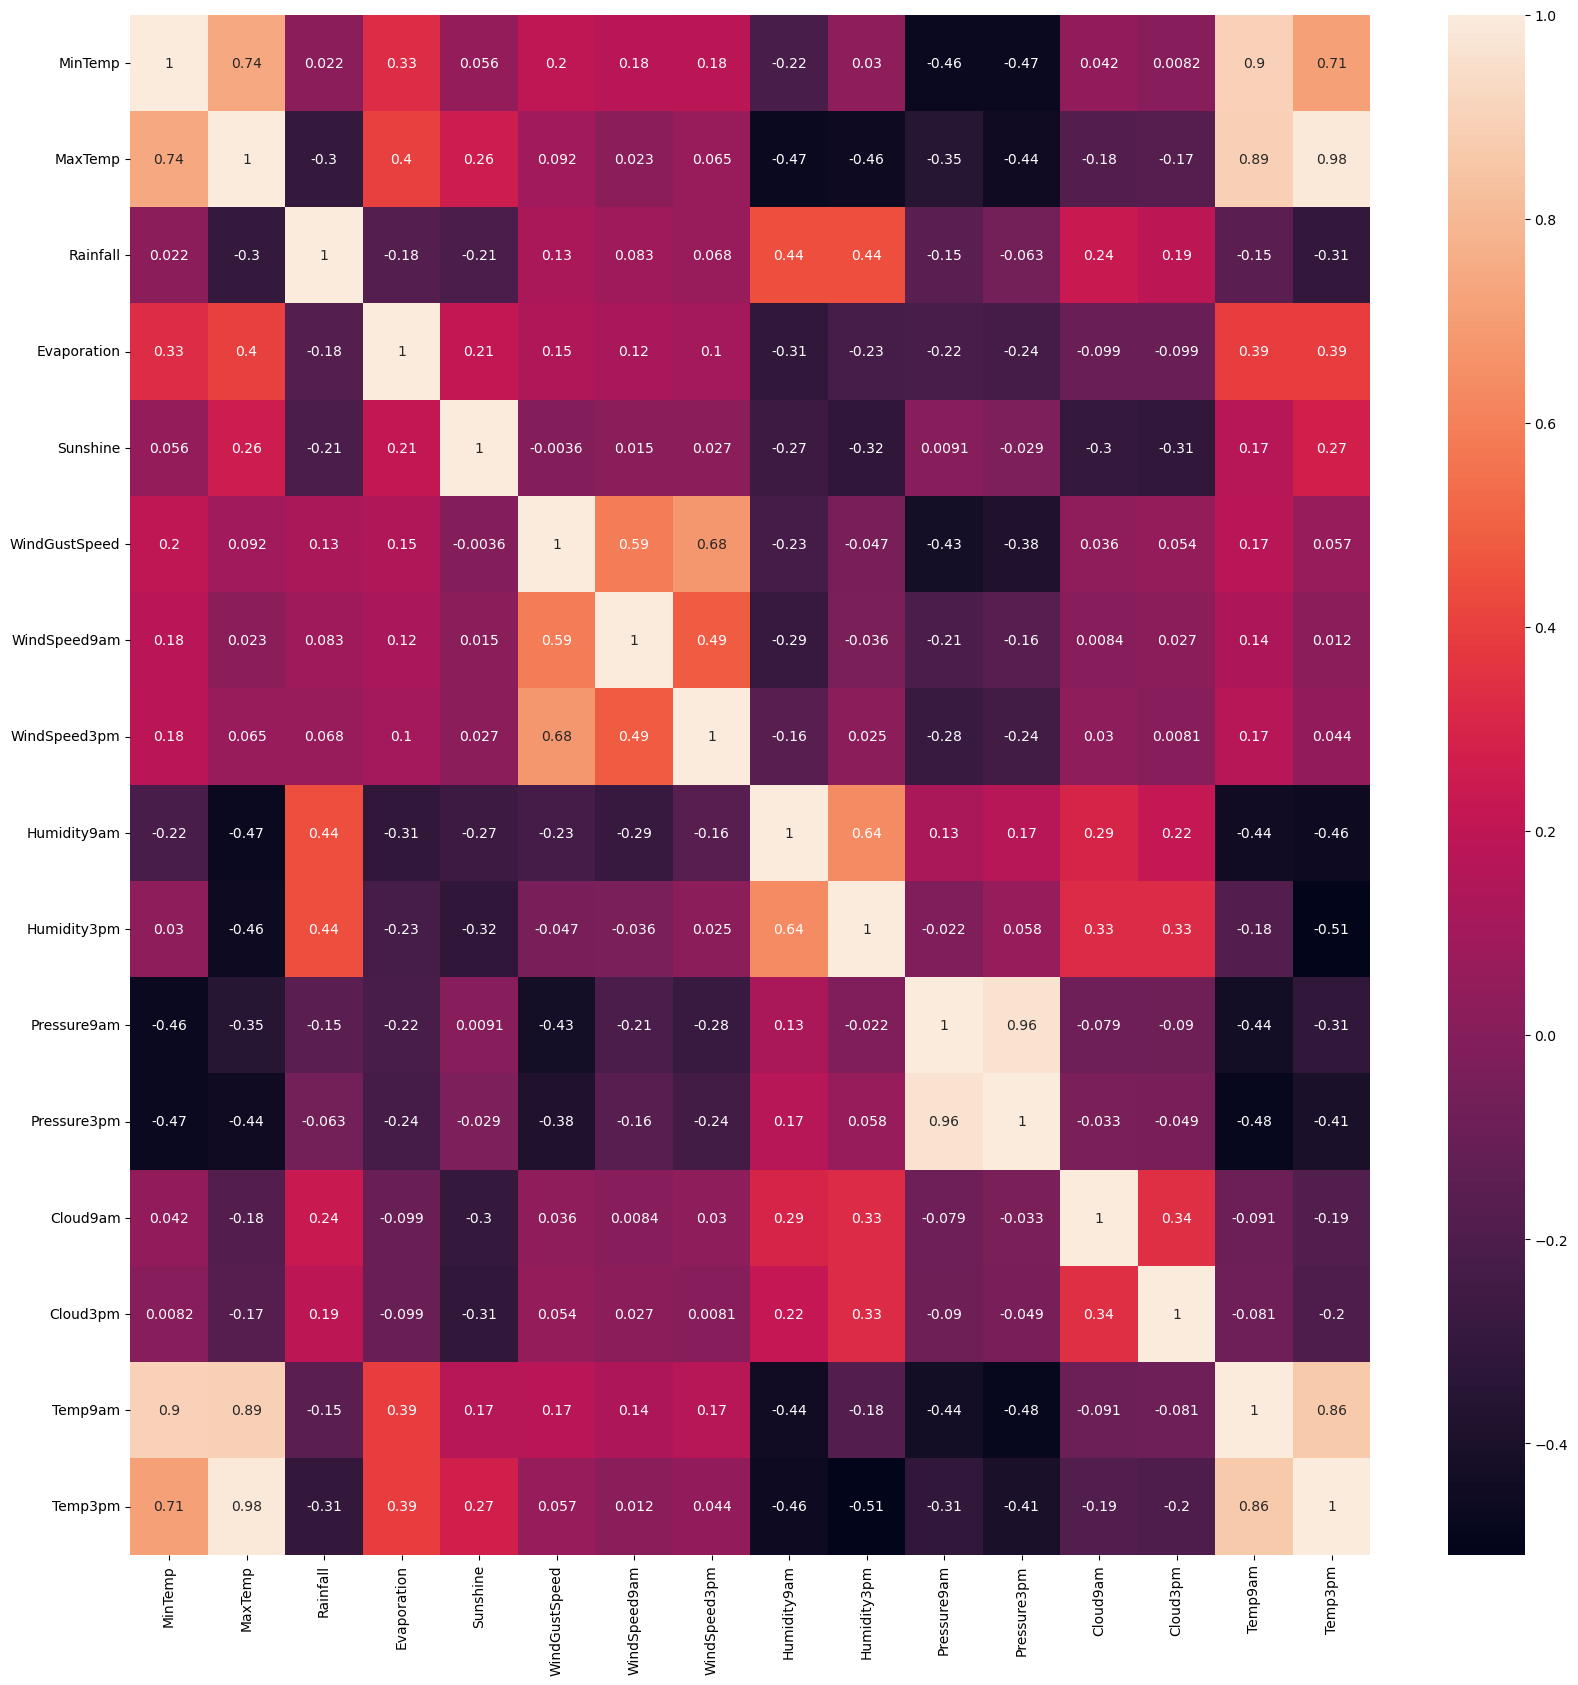

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


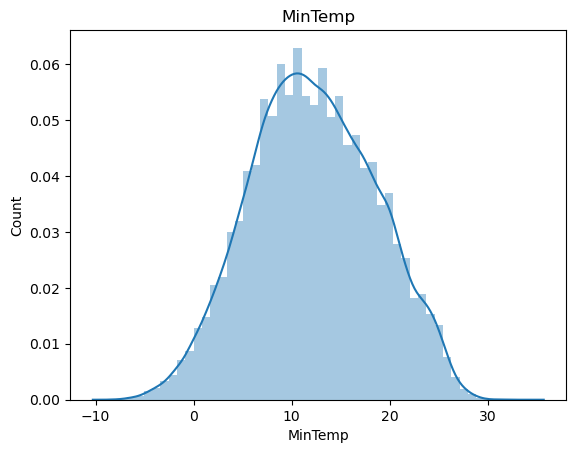

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


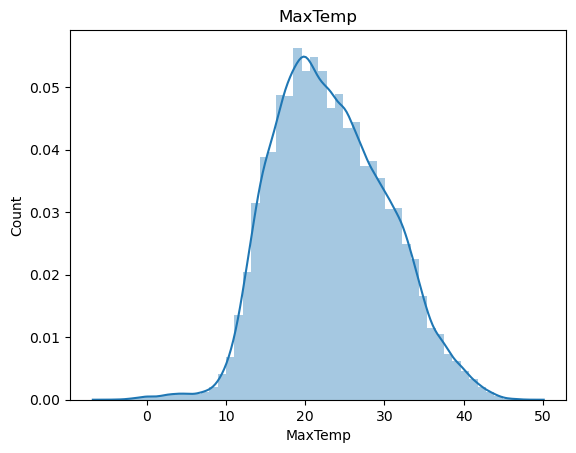

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


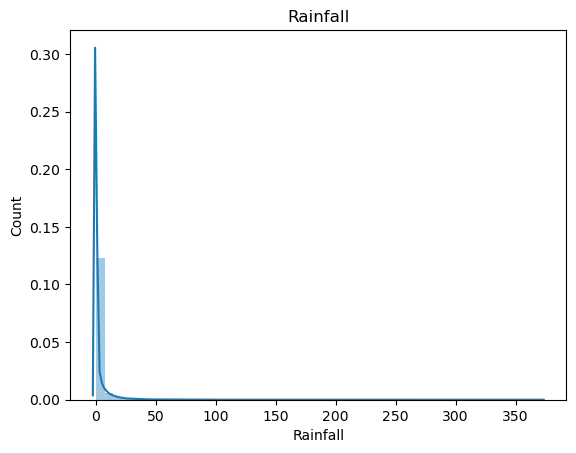

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


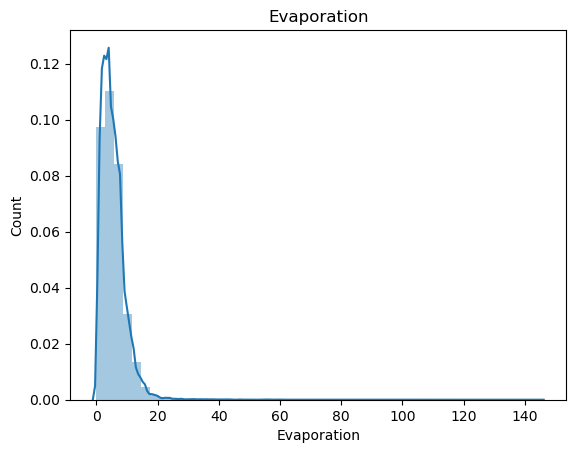

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


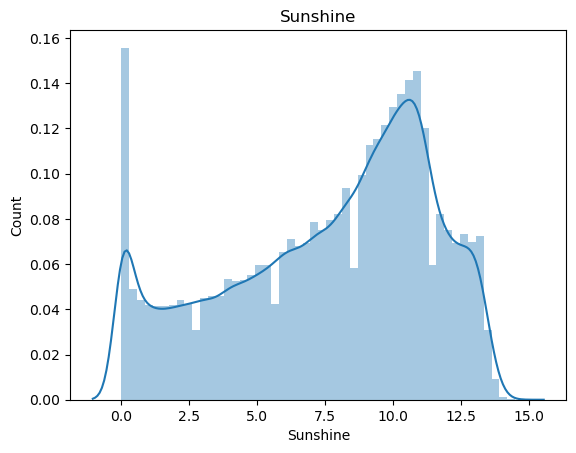

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


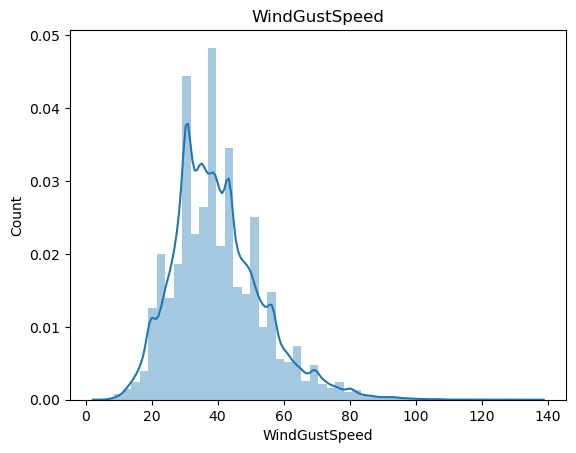

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


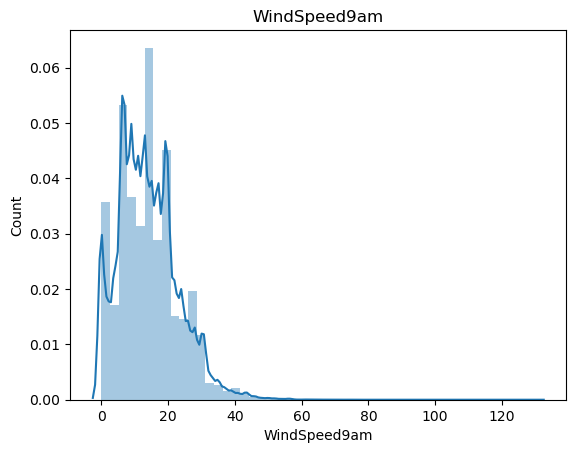

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


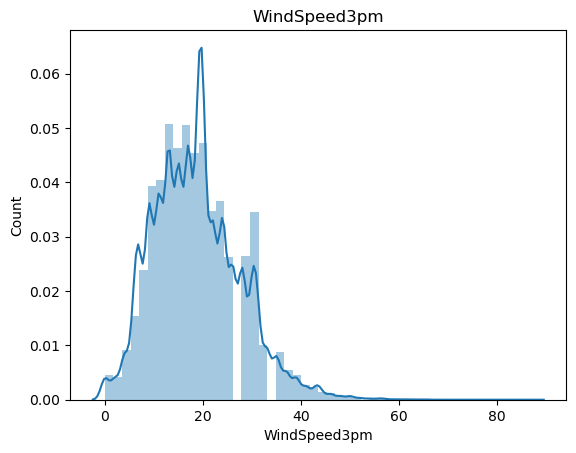

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


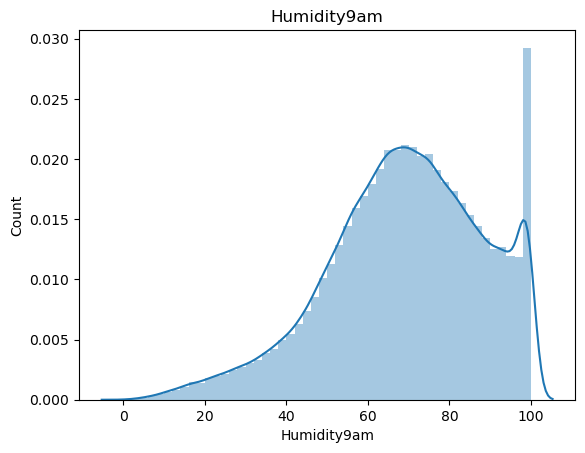

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


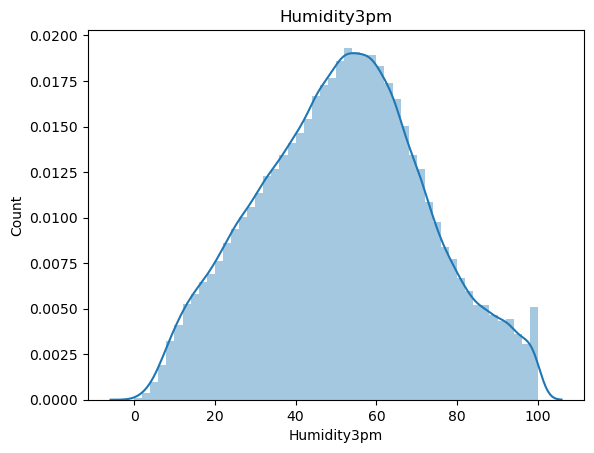

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


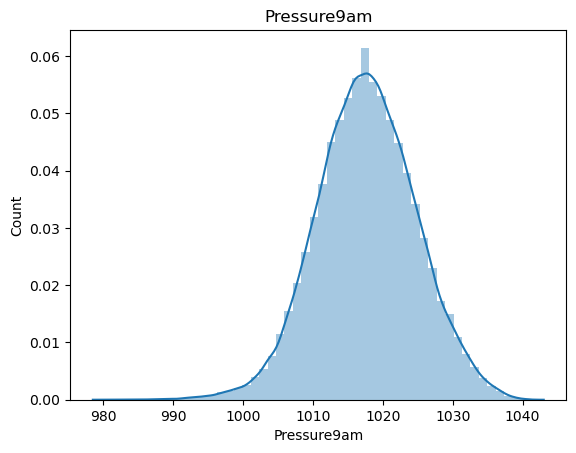

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


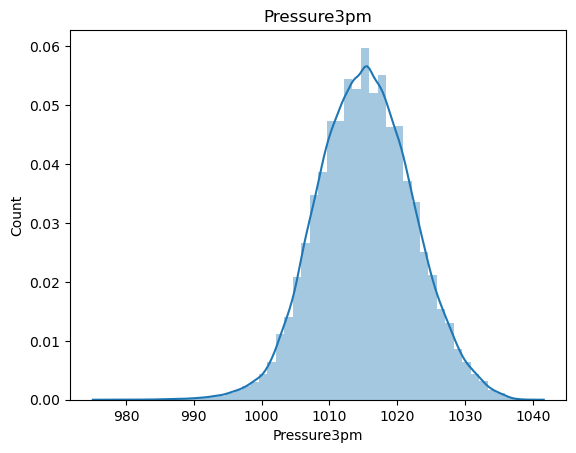

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


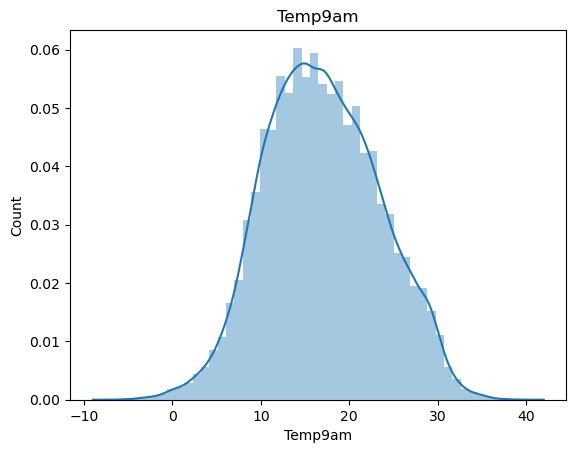

<Figure size 1500x1500 with 0 Axes>

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


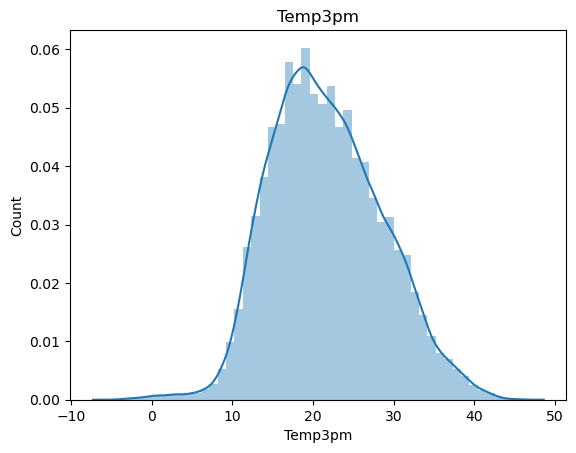

<Figure size 1500x1500 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

In [12]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [13]:
df.isnull().sum()*100/len(df)

Date                  0.000000
Location              0.000000
MinTemp               0.000000
MaxTemp               0.000000
Rainfall              0.000000
Evaporation           0.000000
Sunshine              0.000000
WindGustDir           7.098859
WindGustSpeed         0.000000
WindDir9am            7.263853
WindDir3pm            2.906641
WindSpeed9am          0.000000
WindSpeed3pm          0.000000
Humidity9am           0.000000
Humidity3pm           0.000000
Pressure9am           0.000000
Pressure3pm           0.000000
Cloud9am              0.000000
Cloud3pm              0.000000
Temp9am               0.000000
Temp3pm               0.000000
CloudBurst Today      2.241853
CloudBurstTomorrow    2.245978
dtype: float64

In [14]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [15]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [16]:
df["CloudBurst Today"] = pd.get_dummies(df["CloudBurst Today"], drop_first = True)
df["CloudBurstTomorrow"] = pd.get_dummies(df["CloudBurstTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Almora,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,Almora,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,Almora,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,Almora,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,Almora,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [17]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["CloudBurstTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['19-12-2007', '30-01-2008', '24-12-2007', '13-04-2008', '19-06-2008',
       '02-11-2007', '03-11-2007', '20-12-2007', '03-12-2007', '21-12-2007',
       ...
       '29-04-2008', '25-04-2008', '14-01-2008', '14-02-2008', '19-08-2008',
       '29-03-2008', '29-02-2008', '08-03-2008', '19-07-2008', '01-01-2008'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'Tehri Garhwal',
       'MountGambier', 'Albany', 'Witchcliffe', 'Uttarkashi', 'MountGinini',
       'Bageshwar', 'Darwin', 'Pauri_Garhwal', 'Pauri_GarhwalAirport',
       'Ballarat', 'GoldCoast', 'Watsonia', 'Uddham', 'Hobart', 'Wollongong',
       'Champavat', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Almora', 'Perth', 'Melbourne', 'Nuriootpa', 'Chamoli',
       'Nainital', 'PerthAirport', 'Tuggeranong', 'Haridwar', 'Bendigo',
       'Canberra', 'Pithoragarh', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil

In [18]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date                  0.0
Location              0.0
MinTemp               0.0
MaxTemp               0.0
Rainfall              0.0
Evaporation           0.0
Sunshine              0.0
WindGustDir           0.0
WindGustSpeed         0.0
WindDir9am            0.0
WindDir3pm            0.0
WindSpeed9am          0.0
WindSpeed3pm          0.0
Humidity9am           0.0
Humidity3pm           0.0
Pressure9am           0.0
Pressure3pm           0.0
Cloud9am              0.0
Cloud3pm              0.0
Temp9am               0.0
Temp3pm               0.0
CloudBurst Today      0.0
CloudBurstTomorrow    0.0
dtype: float64

In [21]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [22]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [23]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [24]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,NaN,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,NaN,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,NaN,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,NaN,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,NaN,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


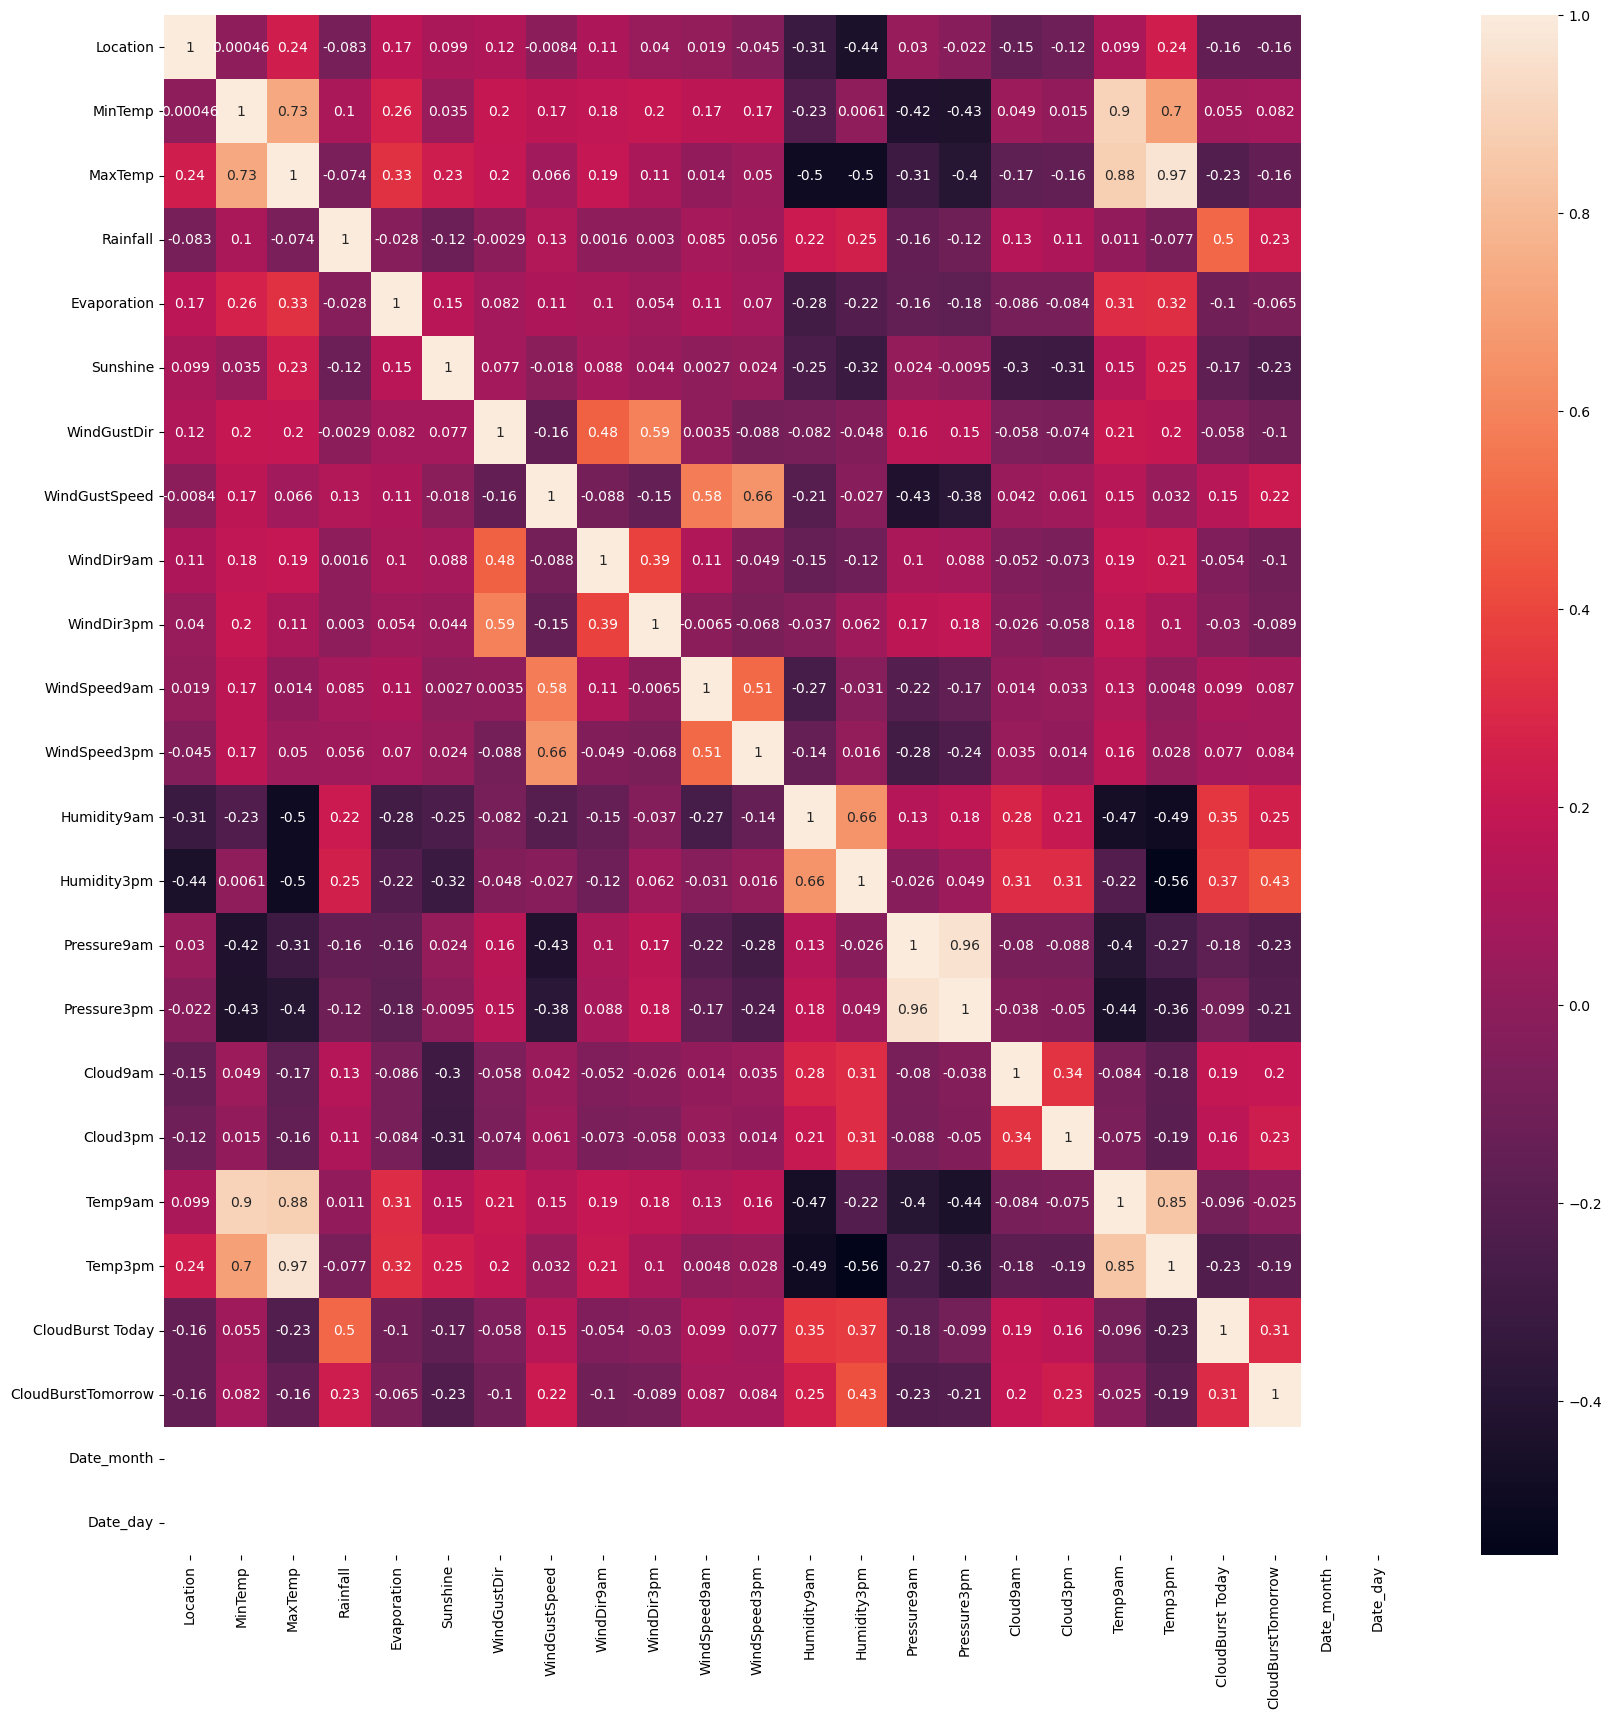

In [25]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
g=sns.heatmap(corrmat,annot=True)

C:\Users\zeel sheth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CloudBurstTomorrow', ylabel='count'>

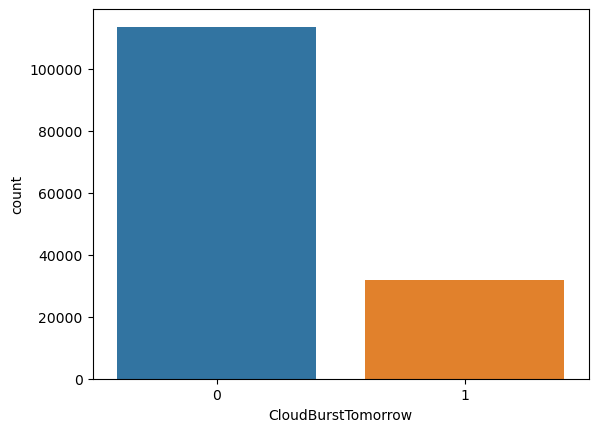

In [26]:
sns.countplot(df["CloudBurstTomorrow"])

In [27]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,NaN,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,NaN,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,NaN,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,NaN,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,NaN,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49.0,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49.0,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49.0,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49.0,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


In [28]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [29]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [30]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [31]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [32]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [33]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [34]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [35]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [36]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [37]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [38]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [39]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [40]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [41]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [42]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [43]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [44]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [45]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [46]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [47]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [48]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [49]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [50]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [51]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [52]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

In [53]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


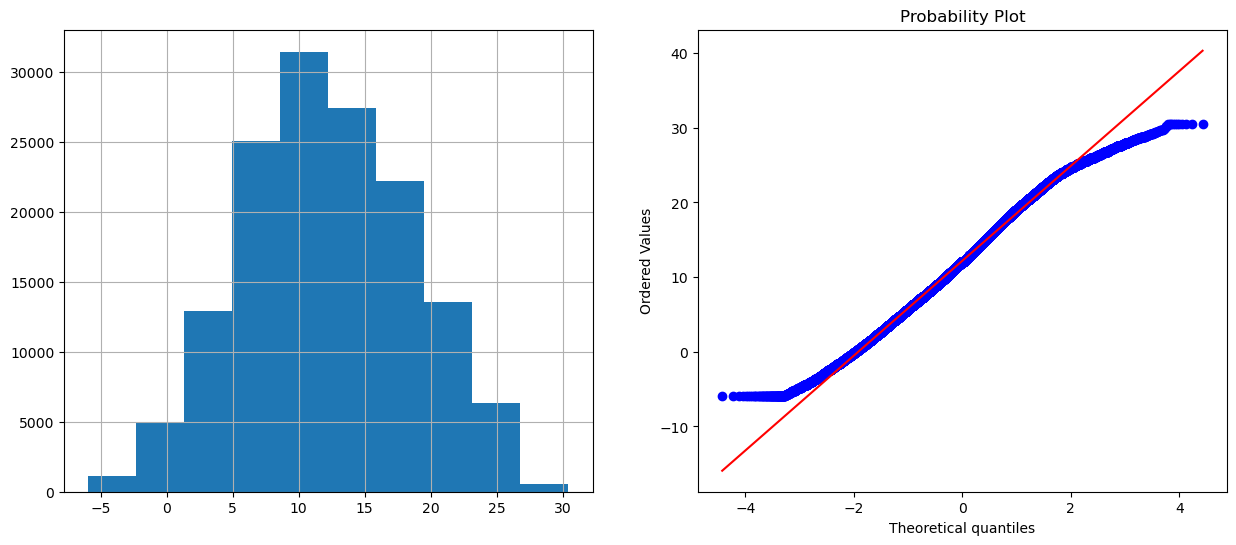

MaxTemp


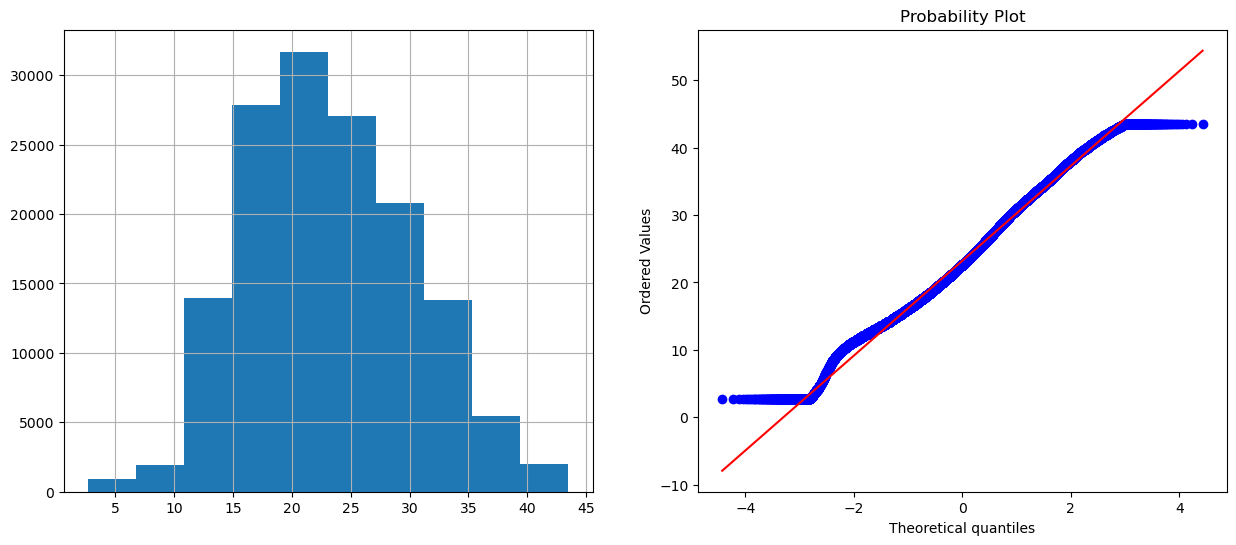

Rainfall


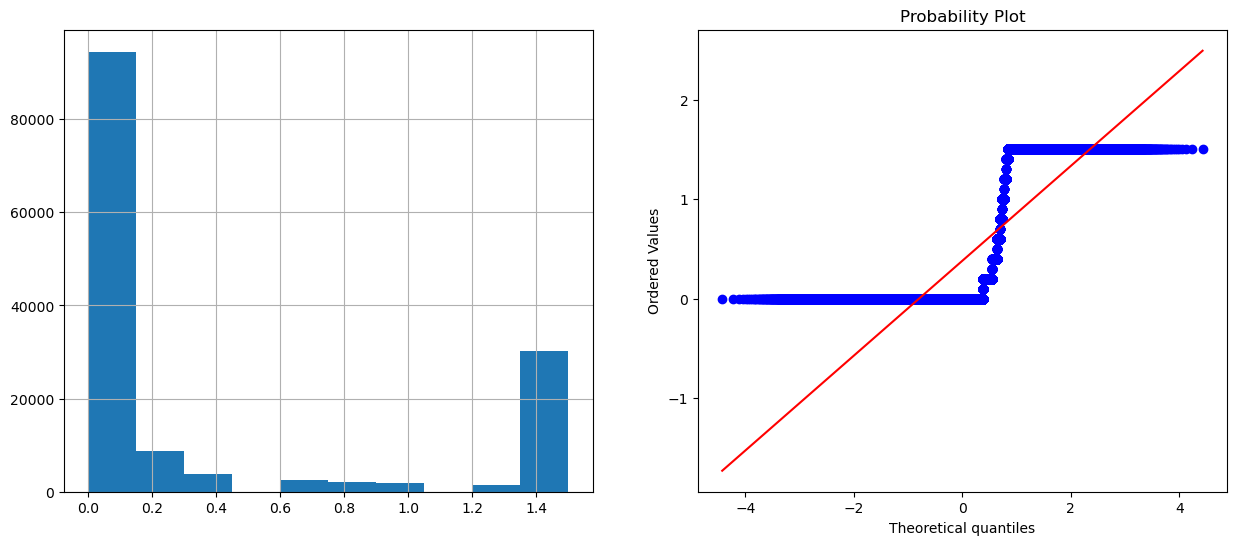

Evaporation


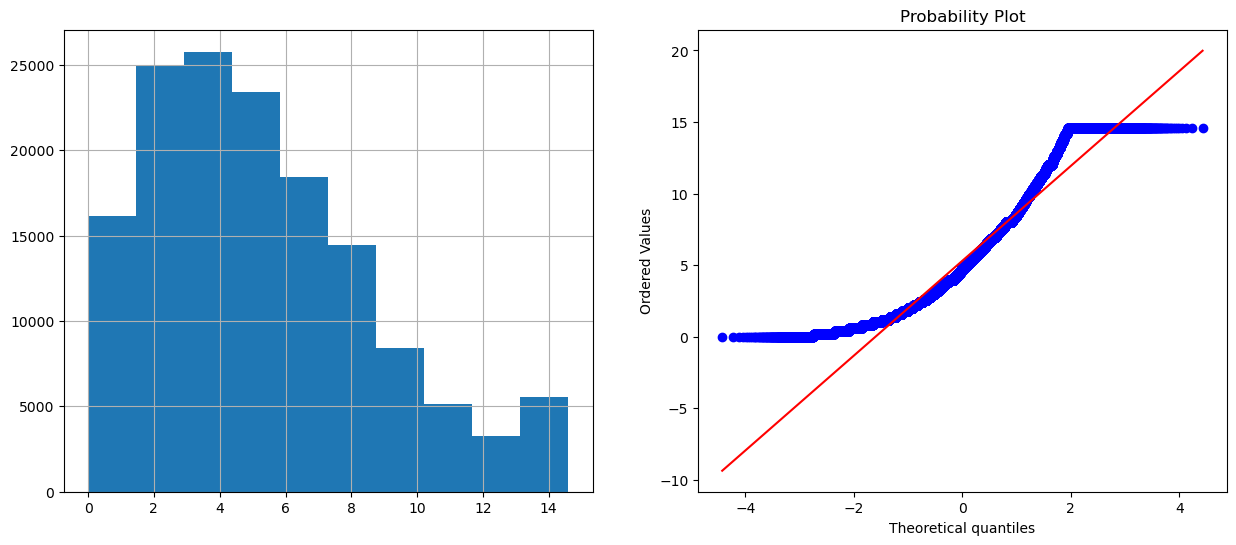

Sunshine


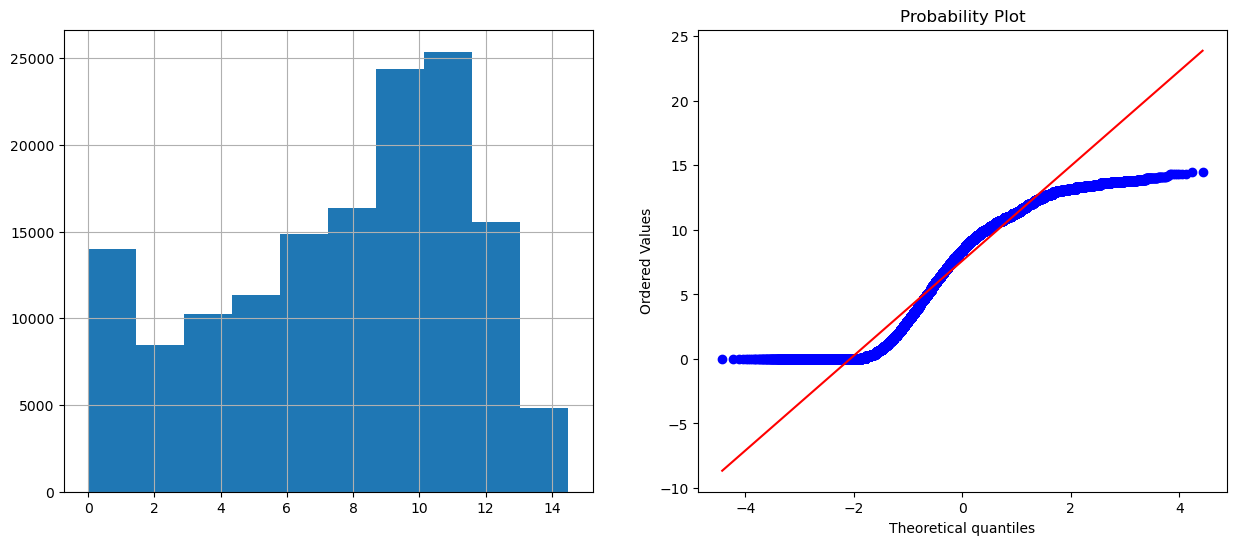

WindGustSpeed


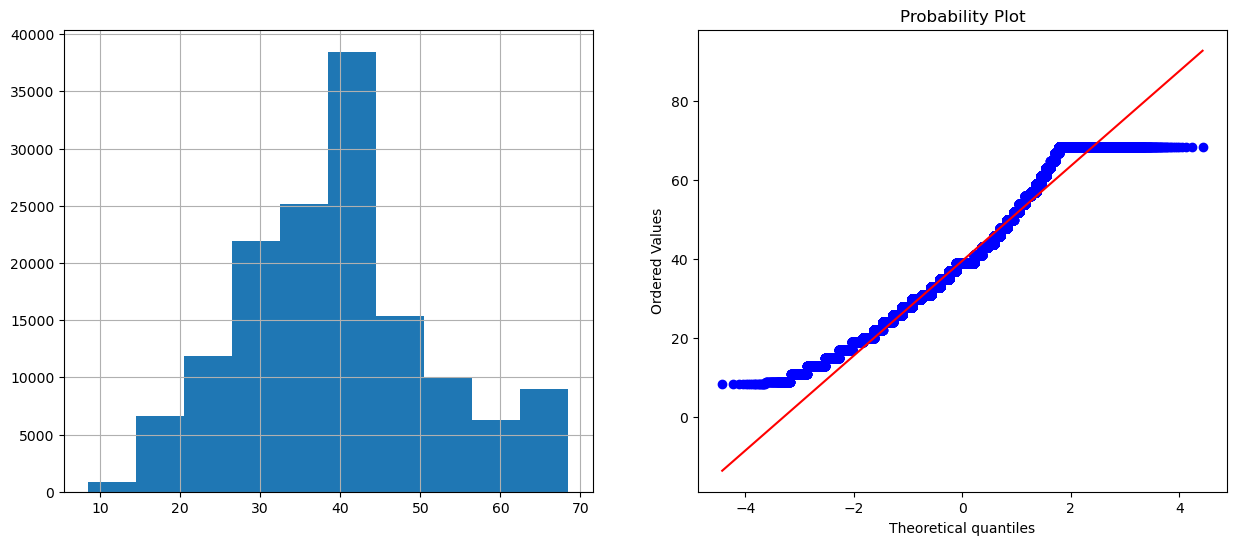

WindSpeed9am


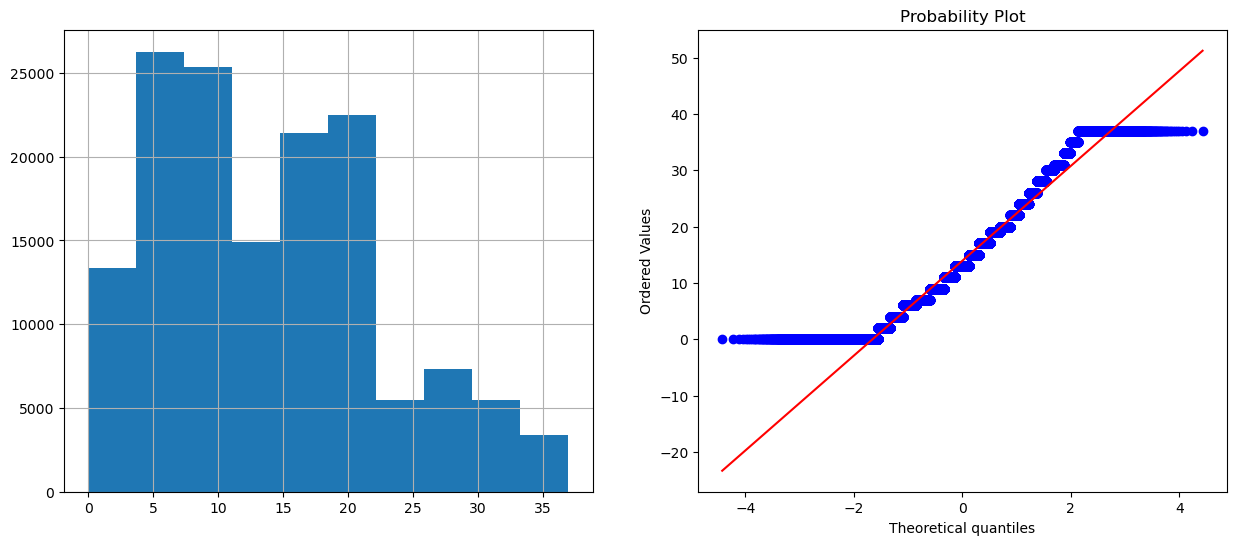

WindSpeed3pm


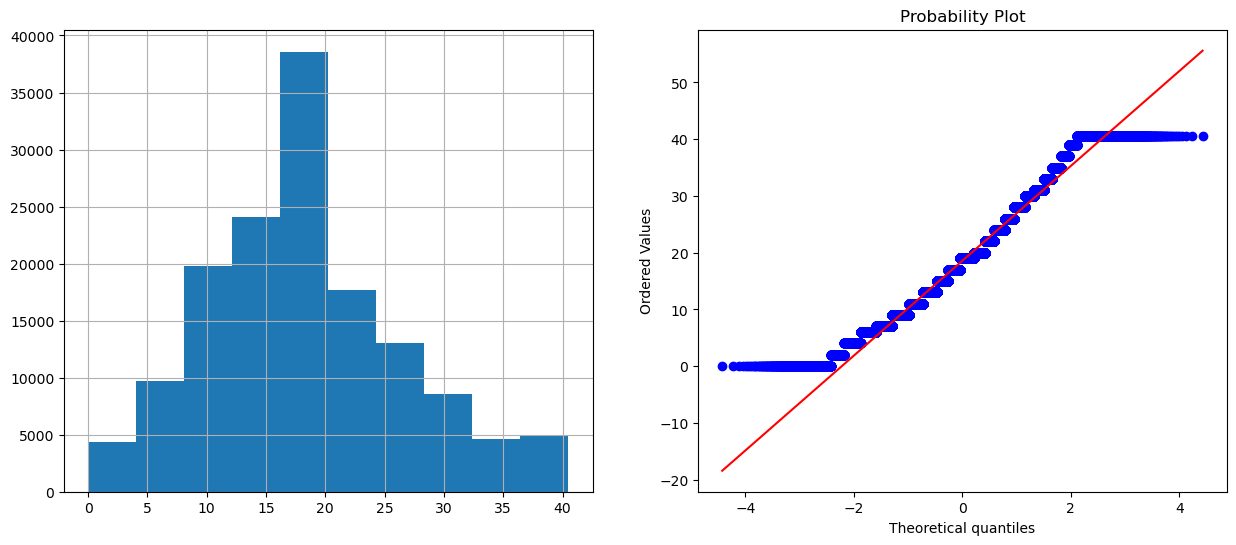

Humidity9am


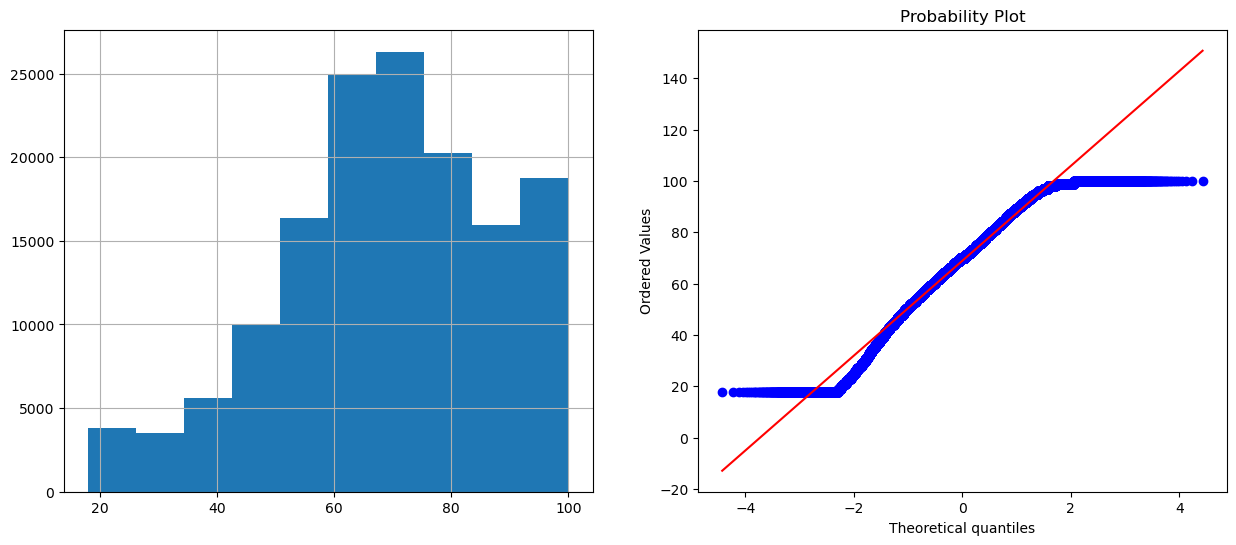

Humidity3pm


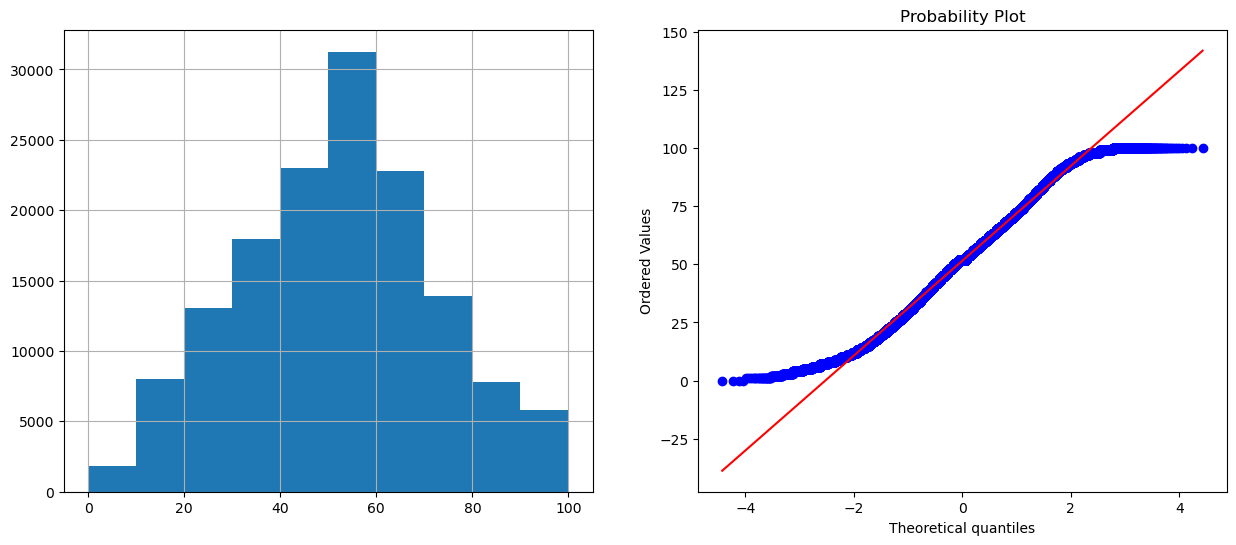

Pressure9am


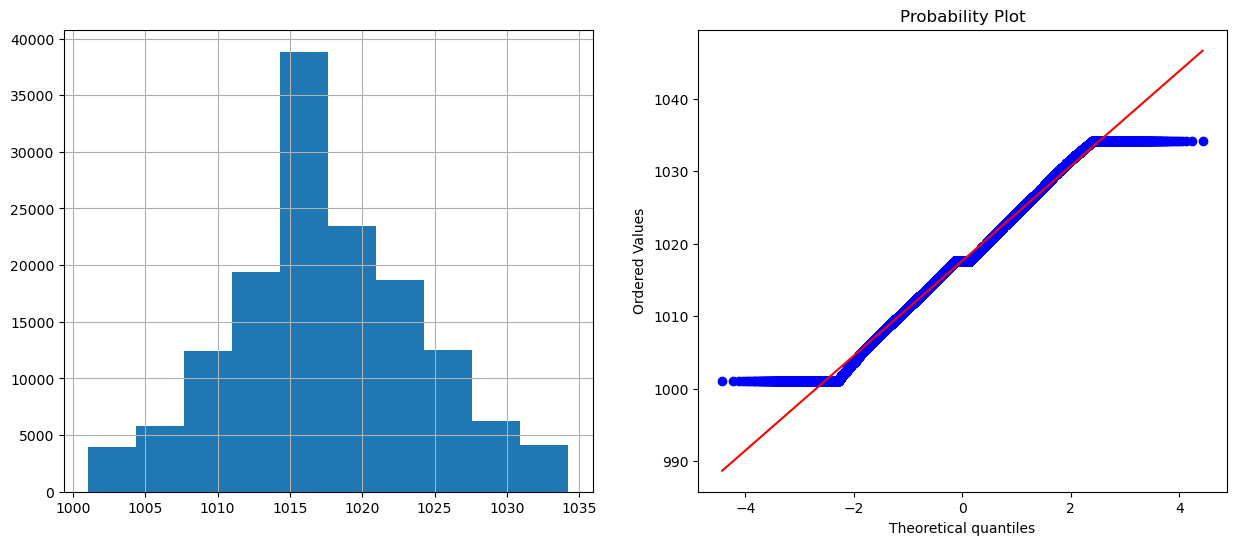

Pressure3pm


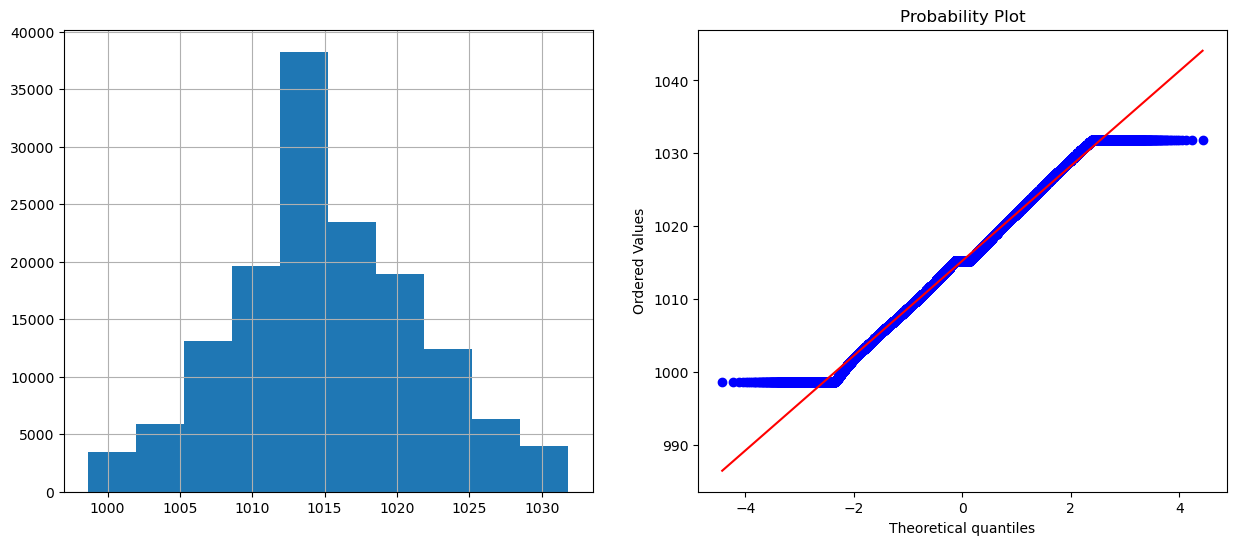

Temp9am


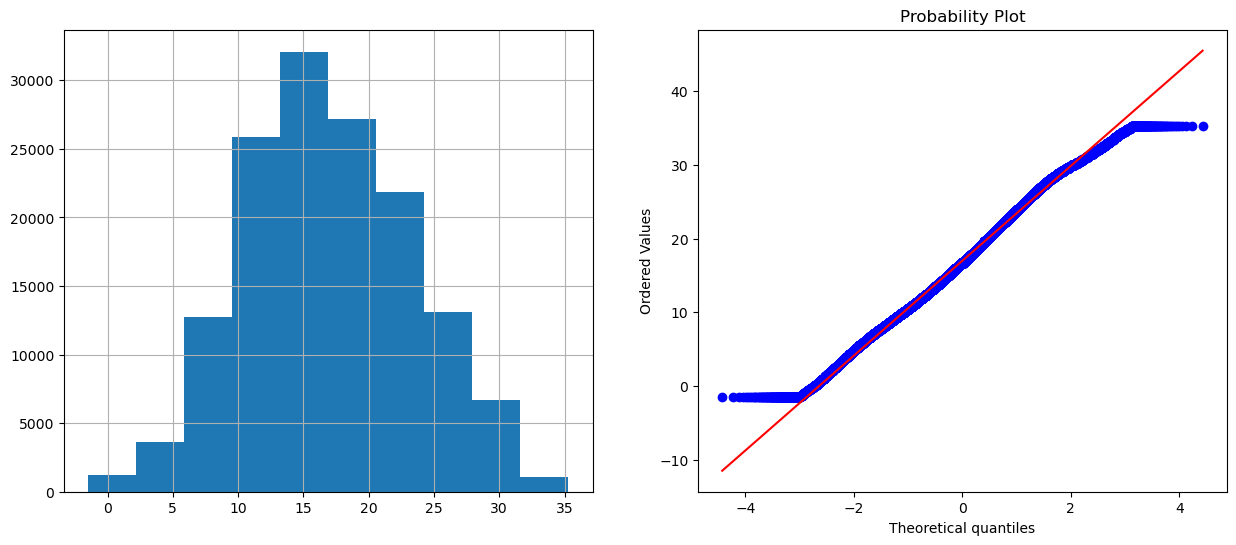

Temp3pm


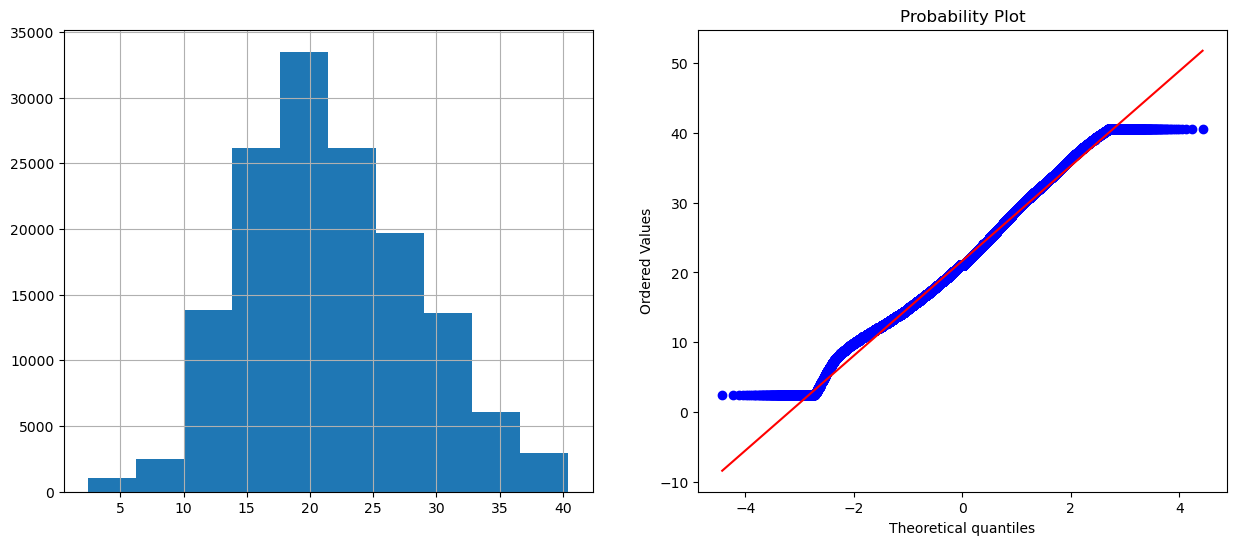

In [54]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [55]:
df.to_csv("preprocessed_1.csv", index=False)

In [56]:
X = df.drop(["CloudBurstTomorrow", "Date"], axis=1)
Y = df["CloudBurstTomorrow"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [59]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: CloudBurstTomorrow, Length: 116368, dtype: uint8

In [60]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 90866, 1: 25502})
The number of classes after fit Counter({0: 90866, 1: 90866})


In [61]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.050311
0:	total: 192ms	remaining: 6m 23s
1:	total: 219ms	remaining: 3m 38s
2:	total: 246ms	remaining: 2m 43s
3:	total: 271ms	remaining: 2m 15s
4:	total: 296ms	remaining: 1m 58s
5:	total: 323ms	remaining: 1m 47s
6:	total: 350ms	remaining: 1m 39s
7:	total: 376ms	remaining: 1m 33s
8:	total: 407ms	remaining: 1m 30s
9:	total: 441ms	remaining: 1m 27s
10:	total: 466ms	remaining: 1m 24s
11:	total: 493ms	remaining: 1m 21s
12:	total: 520ms	remaining: 1m 19s
13:	total: 547ms	remaining: 1m 17s
14:	total: 573ms	remaining: 1m 15s
15:	total: 599ms	remaining: 1m 14s
16:	total: 631ms	remaining: 1m 13s
17:	total: 668ms	remaining: 1m 13s
18:	total: 695ms	remaining: 1m 12s
19:	total: 722ms	remaining: 1m 11s
20:	total: 746ms	remaining: 1m 10s
21:	total: 772ms	remaining: 1m 9s
22:	total: 798ms	remaining: 1m 8s
23:	total: 825ms	remaining: 1m 7s
24:	total: 864ms	remaining: 1m 8s
25:	total: 890ms	remaining: 1m 7s
26:	total: 929ms	remaining: 1m 7s
27:	total: 953ms	remaining: 1m 7s
28:	tot

241:	total: 6.73s	remaining: 48.9s
242:	total: 6.76s	remaining: 48.9s
243:	total: 6.78s	remaining: 48.8s
244:	total: 6.81s	remaining: 48.8s
245:	total: 6.83s	remaining: 48.7s
246:	total: 6.86s	remaining: 48.7s
247:	total: 6.88s	remaining: 48.6s
248:	total: 6.91s	remaining: 48.6s
249:	total: 6.94s	remaining: 48.6s
250:	total: 6.97s	remaining: 48.6s
251:	total: 7s	remaining: 48.5s
252:	total: 7.02s	remaining: 48.5s
253:	total: 7.05s	remaining: 48.4s
254:	total: 7.08s	remaining: 48.4s
255:	total: 7.1s	remaining: 48.4s
256:	total: 7.13s	remaining: 48.3s
257:	total: 7.16s	remaining: 48.3s
258:	total: 7.19s	remaining: 48.3s
259:	total: 7.22s	remaining: 48.3s
260:	total: 7.24s	remaining: 48.3s
261:	total: 7.27s	remaining: 48.2s
262:	total: 7.29s	remaining: 48.2s
263:	total: 7.32s	remaining: 48.1s
264:	total: 7.35s	remaining: 48.1s
265:	total: 7.37s	remaining: 48.1s
266:	total: 7.4s	remaining: 48s
267:	total: 7.43s	remaining: 48s
268:	total: 7.45s	remaining: 48s
269:	total: 7.48s	remaining: 47

479:	total: 15.8s	remaining: 50.1s
480:	total: 15.9s	remaining: 50.1s
481:	total: 15.9s	remaining: 50s
482:	total: 15.9s	remaining: 50s
483:	total: 15.9s	remaining: 49.9s
484:	total: 16s	remaining: 49.9s
485:	total: 16s	remaining: 49.8s
486:	total: 16s	remaining: 49.8s
487:	total: 16.1s	remaining: 49.8s
488:	total: 16.1s	remaining: 49.7s
489:	total: 16.1s	remaining: 49.7s
490:	total: 16.1s	remaining: 49.6s
491:	total: 16.2s	remaining: 49.6s
492:	total: 16.2s	remaining: 49.5s
493:	total: 16.2s	remaining: 49.5s
494:	total: 16.2s	remaining: 49.4s
495:	total: 16.3s	remaining: 49.4s
496:	total: 16.3s	remaining: 49.3s
497:	total: 16.3s	remaining: 49.2s
498:	total: 16.4s	remaining: 49.2s
499:	total: 16.4s	remaining: 49.2s
500:	total: 16.4s	remaining: 49.2s
501:	total: 16.5s	remaining: 49.1s
502:	total: 16.5s	remaining: 49.1s
503:	total: 16.5s	remaining: 49s
504:	total: 16.6s	remaining: 49s
505:	total: 16.6s	remaining: 49s
506:	total: 16.6s	remaining: 48.9s
507:	total: 16.6s	remaining: 48.9s
5

716:	total: 22.5s	remaining: 40.3s
717:	total: 22.5s	remaining: 40.2s
718:	total: 22.6s	remaining: 40.2s
719:	total: 22.6s	remaining: 40.1s
720:	total: 22.6s	remaining: 40.1s
721:	total: 22.6s	remaining: 40.1s
722:	total: 22.7s	remaining: 40s
723:	total: 22.7s	remaining: 40s
724:	total: 22.7s	remaining: 40s
725:	total: 22.8s	remaining: 39.9s
726:	total: 22.8s	remaining: 39.9s
727:	total: 22.8s	remaining: 39.9s
728:	total: 22.8s	remaining: 39.8s
729:	total: 22.9s	remaining: 39.8s
730:	total: 22.9s	remaining: 39.7s
731:	total: 22.9s	remaining: 39.7s
732:	total: 22.9s	remaining: 39.7s
733:	total: 23s	remaining: 39.6s
734:	total: 23s	remaining: 39.6s
735:	total: 23s	remaining: 39.5s
736:	total: 23s	remaining: 39.5s
737:	total: 23.1s	remaining: 39.5s
738:	total: 23.1s	remaining: 39.4s
739:	total: 23.1s	remaining: 39.4s
740:	total: 23.2s	remaining: 39.4s
741:	total: 23.3s	remaining: 39.4s
742:	total: 23.4s	remaining: 39.5s
743:	total: 23.4s	remaining: 39.6s
744:	total: 23.5s	remaining: 39.6s

961:	total: 31.7s	remaining: 34.2s
962:	total: 31.8s	remaining: 34.3s
963:	total: 31.9s	remaining: 34.3s
964:	total: 32s	remaining: 34.3s
965:	total: 32.1s	remaining: 34.4s
966:	total: 32.2s	remaining: 34.4s
967:	total: 32.3s	remaining: 34.4s
968:	total: 32.3s	remaining: 34.4s
969:	total: 32.4s	remaining: 34.4s
970:	total: 32.5s	remaining: 34.4s
971:	total: 32.6s	remaining: 34.4s
972:	total: 32.6s	remaining: 34.4s
973:	total: 32.7s	remaining: 34.5s
974:	total: 32.8s	remaining: 34.5s
975:	total: 32.9s	remaining: 34.5s
976:	total: 32.9s	remaining: 34.5s
977:	total: 33s	remaining: 34.5s
978:	total: 33.1s	remaining: 34.5s
979:	total: 33.2s	remaining: 34.5s
980:	total: 33.3s	remaining: 34.5s
981:	total: 33.3s	remaining: 34.5s
982:	total: 33.4s	remaining: 34.5s
983:	total: 33.5s	remaining: 34.6s
984:	total: 33.5s	remaining: 34.6s
985:	total: 33.6s	remaining: 34.6s
986:	total: 33.7s	remaining: 34.6s
987:	total: 33.8s	remaining: 34.6s
988:	total: 33.9s	remaining: 34.6s
989:	total: 33.9s	remain

1199:	total: 41.8s	remaining: 27.8s
1200:	total: 41.8s	remaining: 27.8s
1201:	total: 41.8s	remaining: 27.8s
1202:	total: 41.8s	remaining: 27.7s
1203:	total: 41.9s	remaining: 27.7s
1204:	total: 41.9s	remaining: 27.6s
1205:	total: 41.9s	remaining: 27.6s
1206:	total: 41.9s	remaining: 27.5s
1207:	total: 42s	remaining: 27.5s
1208:	total: 42s	remaining: 27.5s
1209:	total: 42s	remaining: 27.4s
1210:	total: 42s	remaining: 27.4s
1211:	total: 42.1s	remaining: 27.4s
1212:	total: 42.1s	remaining: 27.3s
1213:	total: 42.1s	remaining: 27.3s
1214:	total: 42.1s	remaining: 27.2s
1215:	total: 42.2s	remaining: 27.2s
1216:	total: 42.2s	remaining: 27.1s
1217:	total: 42.2s	remaining: 27.1s
1218:	total: 42.3s	remaining: 27.1s
1219:	total: 42.3s	remaining: 27s
1220:	total: 42.3s	remaining: 27s
1221:	total: 42.3s	remaining: 26.9s
1222:	total: 42.4s	remaining: 26.9s
1223:	total: 42.4s	remaining: 26.9s
1224:	total: 42.4s	remaining: 26.8s
1225:	total: 42.4s	remaining: 26.8s
1226:	total: 42.5s	remaining: 26.8s
1227

1437:	total: 48s	remaining: 18.8s
1438:	total: 48s	remaining: 18.7s
1439:	total: 48s	remaining: 18.7s
1440:	total: 48.1s	remaining: 18.6s
1441:	total: 48.1s	remaining: 18.6s
1442:	total: 48.1s	remaining: 18.6s
1443:	total: 48.1s	remaining: 18.5s
1444:	total: 48.2s	remaining: 18.5s
1445:	total: 48.2s	remaining: 18.5s
1446:	total: 48.2s	remaining: 18.4s
1447:	total: 48.2s	remaining: 18.4s
1448:	total: 48.3s	remaining: 18.4s
1449:	total: 48.3s	remaining: 18.3s
1450:	total: 48.3s	remaining: 18.3s
1451:	total: 48.3s	remaining: 18.2s
1452:	total: 48.4s	remaining: 18.2s
1453:	total: 48.4s	remaining: 18.2s
1454:	total: 48.4s	remaining: 18.1s
1455:	total: 48.5s	remaining: 18.1s
1456:	total: 48.5s	remaining: 18.1s
1457:	total: 48.5s	remaining: 18s
1458:	total: 48.5s	remaining: 18s
1459:	total: 48.5s	remaining: 18s
1460:	total: 48.6s	remaining: 17.9s
1461:	total: 48.6s	remaining: 17.9s
1462:	total: 48.6s	remaining: 17.9s
1463:	total: 48.7s	remaining: 17.8s
1464:	total: 48.7s	remaining: 17.8s
1465

1676:	total: 54.2s	remaining: 10.4s
1677:	total: 54.3s	remaining: 10.4s
1678:	total: 54.3s	remaining: 10.4s
1679:	total: 54.3s	remaining: 10.3s
1680:	total: 54.4s	remaining: 10.3s
1681:	total: 54.4s	remaining: 10.3s
1682:	total: 54.4s	remaining: 10.2s
1683:	total: 54.4s	remaining: 10.2s
1684:	total: 54.4s	remaining: 10.2s
1685:	total: 54.5s	remaining: 10.1s
1686:	total: 54.5s	remaining: 10.1s
1687:	total: 54.5s	remaining: 10.1s
1688:	total: 54.6s	remaining: 10s
1689:	total: 54.6s	remaining: 10s
1690:	total: 54.6s	remaining: 9.98s
1691:	total: 54.6s	remaining: 9.95s
1692:	total: 54.7s	remaining: 9.91s
1693:	total: 54.7s	remaining: 9.88s
1694:	total: 54.7s	remaining: 9.85s
1695:	total: 54.8s	remaining: 9.81s
1696:	total: 54.8s	remaining: 9.78s
1697:	total: 54.8s	remaining: 9.75s
1698:	total: 54.8s	remaining: 9.71s
1699:	total: 54.9s	remaining: 9.68s
1700:	total: 54.9s	remaining: 9.65s
1701:	total: 54.9s	remaining: 9.61s
1702:	total: 54.9s	remaining: 9.58s
1703:	total: 55s	remaining: 9.55

1910:	total: 1m	remaining: 2.81s
1911:	total: 1m	remaining: 2.78s
1912:	total: 1m	remaining: 2.75s
1913:	total: 1m	remaining: 2.72s
1914:	total: 1m	remaining: 2.69s
1915:	total: 1m	remaining: 2.65s
1916:	total: 1m	remaining: 2.62s
1917:	total: 1m	remaining: 2.59s
1918:	total: 1m	remaining: 2.56s
1919:	total: 1m	remaining: 2.52s
1920:	total: 1m	remaining: 2.49s
1921:	total: 1m	remaining: 2.46s
1922:	total: 1m	remaining: 2.43s
1923:	total: 1m	remaining: 2.4s
1924:	total: 1m	remaining: 2.37s
1925:	total: 1m	remaining: 2.33s
1926:	total: 1m	remaining: 2.3s
1927:	total: 1m	remaining: 2.27s
1928:	total: 1m	remaining: 2.24s
1929:	total: 1m	remaining: 2.21s
1930:	total: 1m	remaining: 2.18s
1931:	total: 1m	remaining: 2.14s
1932:	total: 1m	remaining: 2.11s
1933:	total: 1m	remaining: 2.08s
1934:	total: 1m 1s	remaining: 2.05s
1935:	total: 1m 1s	remaining: 2.02s
1936:	total: 1m 1s	remaining: 1.99s
1937:	total: 1m 1s	remaining: 1.95s
1938:	total: 1m 1s	remaining: 1.92s
1939:	total: 1m 1s	remaining: 

In [62]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[21521  1196]
 [ 2824  3551]]
0.8618176818369311
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.85      0.86      0.85     29092



In [63]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [64]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[20580  2137]
 [ 2433  3942]]
0.8429121407947202
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22717
           1       0.65      0.62      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



In [65]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[17557  5160]
 [ 1522  4853]]
0.7703148631926303
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22717
           1       0.48      0.76      0.59      6375

    accuracy                           0.77     29092
   macro avg       0.70      0.77      0.72     29092
weighted avg       0.82      0.77      0.79     29092



In [67]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [68]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[17117  5600]
 [ 1671  4704]]
0.7500687474219717
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     22717
           1       0.46      0.74      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.75      0.77     29092



C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7456854648889534

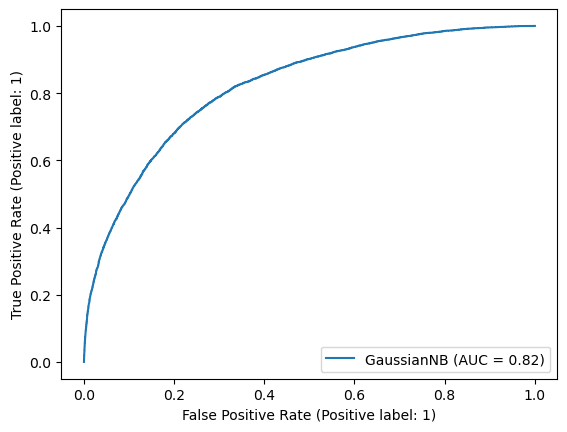

In [69]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [70]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [71]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[17366  5351]
 [ 1862  4513]]
0.7520624226591502
              precision    recall  f1-score   support

           0       0.90      0.76      0.83     22717
           1       0.46      0.71      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.74      0.69     29092
weighted avg       0.81      0.75      0.77     29092



In [72]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
y_pred6 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[21374  1343]
 [ 2860  3515]]
0.8555272927265227
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.72      0.55      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



In [74]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

SVC()

In [75]:
y_pred5 = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

[[17789  4928]
 [ 1584  4791]]
0.7761583940602227
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     22717
           1       0.49      0.75      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092



C:\Users\zeel sheth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.7672996796905143

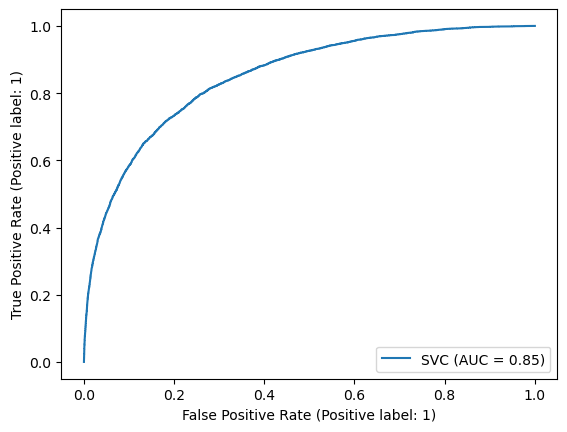

In [76]:
metrics.plot_roc_curve(svc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred5, average=None) 

In [77]:
# joblib.dump(rf, "rf.pkl")
# joblib.dump(cat, "cat.pkl")
# joblib.dump(logreg, "logreg.pkl")
# joblib.dump(gnb, "gnb.pkl")
# joblib.dump(knn, "knn.pkl")
joblib.dump(svc, "svc.pkl")
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\zeel sheth\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zeel sheth\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\zeel sheth\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv("cloudburst.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Almora,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Almora,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Almora,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Almora,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Almora,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.dtypes

Date                   object
Location               object
MinTemp               float64
MaxTemp               float64
Rainfall              float64
Evaporation           float64
Sunshine              float64
WindGustDir            object
WindGustSpeed         float64
WindDir9am             object
WindDir3pm             object
WindSpeed9am          float64
WindSpeed3pm          float64
Humidity9am           float64
Humidity3pm           float64
Pressure9am           float64
Pressure3pm           float64
Cloud9am              float64
Cloud3pm              float64
Temp9am               float64
Temp3pm               float64
CloudBurst Today       object
CloudBurstTomorrow     object
dtype: object

In [4]:
df1 = pd.get_dummies(data = df,columns=['WindGustDir','Date','Location','WindDir3pm','WindDir9am'])
df1

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,...,1,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,...,0,0,0,1,0,0,0,0,0,0
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,0.0,NaN,NaN,31.0,13.0,11.0,51.0,24.0,...,0,0,0,1,0,0,0,0,0,0
145456,3.6,25.3,0.0,NaN,NaN,22.0,13.0,9.0,56.0,21.0,...,0,0,0,1,0,0,0,0,0,0
145457,5.4,26.9,0.0,NaN,NaN,37.0,9.0,9.0,53.0,24.0,...,0,0,0,1,0,0,0,0,0,0
145458,7.8,27.0,0.0,NaN,NaN,28.0,13.0,7.0,51.0,24.0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
def print_uniq_val(df):
    for column in df:
        print(f'{column} : {df[column].unique()}')

In [6]:
print_uniq_val(df1)

MinTemp : [13.4  7.4 12.9  9.2 17.5 14.6 14.3  7.7  9.7 13.1 15.9 12.6  8.4  9.8
 14.1 13.5 11.2 11.5 17.1 20.5 15.3 16.2 16.9 20.1 19.7 12.5 12.  11.3
  9.6 10.5 12.3 13.7 16.1 14.  17.  17.3 17.2 17.4 19.8 14.9 13.9 18.6
 19.3 24.4 18.8 20.8 15.7 18.5 20.4 21.8 22.3 22.  28.  21.5 21.7 23.5
 28.3 18.4 12.4 13.3 18.  18.7 15.5  8.9 15.  15.4 16.  12.8 13.2 13.8
  7.6  8.3 11.  20.9 16.4 10.   8.8  9.3 14.4 10.8 10.1  9.1 10.4 12.2
 10.7  7.8  8.1  7.5  8.2 11.6 13.   9.9  3.5  6.6  7.   5.7  6.2  6.
 10.6  8.6  4.5  5.4  2.1  1.8  7.2  4.6  4.2  5.2  4.1  3.2  4.3  3.7
  3.6  6.9 10.3  3.   2.6  5.1  4.4  4.7  6.7  8.   2.2  1.7  2.8  9.
  6.3 -2.  -1.3  2.   0.5  1.2  0.6  0.9  5.   3.9  3.4  0.  -1.5 -1.7
 -0.4  0.1  4.8  5.9  2.9 -0.6 -0.3 -1.   0.8 -0.1  1.3  3.3  6.5 -0.8
  1.9  6.8  2.7  1.6  5.5  7.3  0.2  5.8  7.1  1.1  1.   6.1  nan  5.3
  4.  11.7  8.5  3.8  6.4  9.5 14.5 15.6 17.8 16.7 18.1 12.1 11.4 18.3
 11.9 21.  11.1 18.2 14.2 11.8 13.6 12.7 15.1 22.9 17.6 21.1 19.4 14.

Date_02-02-2010 : [0 1]
Date_02-02-2011 : [0 1]
Date_02-02-2012 : [0 1]
Date_02-02-2014 : [0 1]
Date_02-02-2015 : [0 1]
Date_02-02-2016 : [0 1]
Date_02-02-2017 : [0 1]
Date_02-03-2008 : [0 1]
Date_02-03-2009 : [0 1]
Date_02-03-2010 : [0 1]
Date_02-03-2011 : [0 1]
Date_02-03-2012 : [0 1]
Date_02-03-2013 : [0 1]
Date_02-03-2014 : [0 1]
Date_02-03-2015 : [0 1]
Date_02-03-2016 : [0 1]
Date_02-03-2017 : [0 1]
Date_02-04-2008 : [0 1]
Date_02-04-2009 : [0 1]
Date_02-04-2010 : [0 1]
Date_02-04-2012 : [0 1]
Date_02-04-2013 : [0 1]
Date_02-04-2014 : [0 1]
Date_02-04-2015 : [0 1]
Date_02-04-2016 : [0 1]
Date_02-04-2017 : [0 1]
Date_02-05-2008 : [0 1]
Date_02-05-2009 : [0 1]
Date_02-05-2010 : [0 1]
Date_02-05-2011 : [0 1]
Date_02-05-2012 : [0 1]
Date_02-05-2013 : [0 1]
Date_02-05-2014 : [0 1]
Date_02-05-2015 : [0 1]
Date_02-05-2016 : [0 1]
Date_02-05-2017 : [0 1]
Date_02-06-2008 : [0 1]
Date_02-06-2009 : [0 1]
Date_02-06-2010 : [0 1]
Date_02-06-2011 : [0 1]
Date_02-06-2012 : [0 1]
Date_02-06-2013 

Date_05-07-2013 : [0 1]
Date_05-07-2014 : [0 1]
Date_05-07-2015 : [0 1]
Date_05-07-2016 : [0 1]
Date_05-08-2008 : [0 1]
Date_05-08-2009 : [0 1]
Date_05-08-2010 : [0 1]
Date_05-08-2011 : [0 1]
Date_05-08-2012 : [0 1]
Date_05-08-2013 : [0 1]
Date_05-08-2014 : [0 1]
Date_05-08-2015 : [0 1]
Date_05-08-2016 : [0 1]
Date_05-09-2008 : [0 1]
Date_05-09-2009 : [0 1]
Date_05-09-2010 : [0 1]
Date_05-09-2011 : [0 1]
Date_05-09-2012 : [0 1]
Date_05-09-2013 : [0 1]
Date_05-09-2014 : [0 1]
Date_05-09-2015 : [0 1]
Date_05-09-2016 : [0 1]
Date_05-10-2008 : [0 1]
Date_05-10-2009 : [0 1]
Date_05-10-2010 : [0 1]
Date_05-10-2011 : [0 1]
Date_05-10-2012 : [0 1]
Date_05-10-2013 : [0 1]
Date_05-10-2014 : [0 1]
Date_05-10-2015 : [0 1]
Date_05-10-2016 : [0 1]
Date_05-11-2007 : [0 1]
Date_05-11-2008 : [0 1]
Date_05-11-2009 : [0 1]
Date_05-11-2010 : [0 1]
Date_05-11-2011 : [0 1]
Date_05-11-2012 : [0 1]
Date_05-11-2013 : [0 1]
Date_05-11-2014 : [0 1]
Date_05-11-2015 : [0 1]
Date_05-11-2016 : [0 1]
Date_05-12-2007 

Date_10-03-2016 : [0 1]
Date_10-03-2017 : [0 1]
Date_10-04-2008 : [0 1]
Date_10-04-2009 : [0 1]
Date_10-04-2010 : [0 1]
Date_10-04-2012 : [0 1]
Date_10-04-2013 : [0 1]
Date_10-04-2014 : [0 1]
Date_10-04-2015 : [0 1]
Date_10-04-2016 : [0 1]
Date_10-04-2017 : [0 1]
Date_10-05-2008 : [0 1]
Date_10-05-2009 : [0 1]
Date_10-05-2010 : [0 1]
Date_10-05-2011 : [0 1]
Date_10-05-2012 : [0 1]
Date_10-05-2013 : [0 1]
Date_10-05-2014 : [0 1]
Date_10-05-2015 : [0 1]
Date_10-05-2016 : [0 1]
Date_10-05-2017 : [0 1]
Date_10-06-2008 : [0 1]
Date_10-06-2009 : [0 1]
Date_10-06-2010 : [0 1]
Date_10-06-2011 : [0 1]
Date_10-06-2012 : [0 1]
Date_10-06-2013 : [0 1]
Date_10-06-2014 : [0 1]
Date_10-06-2015 : [0 1]
Date_10-06-2016 : [0 1]
Date_10-06-2017 : [0 1]
Date_10-07-2008 : [0 1]
Date_10-07-2009 : [0 1]
Date_10-07-2010 : [0 1]
Date_10-07-2011 : [0 1]
Date_10-07-2012 : [0 1]
Date_10-07-2013 : [0 1]
Date_10-07-2014 : [0 1]
Date_10-07-2015 : [0 1]
Date_10-07-2016 : [0 1]
Date_10-08-2008 : [0 1]
Date_10-08-2009 

Date_13-07-2016 : [0 1]
Date_13-08-2008 : [0 1]
Date_13-08-2009 : [0 1]
Date_13-08-2010 : [0 1]
Date_13-08-2011 : [0 1]
Date_13-08-2012 : [0 1]
Date_13-08-2013 : [0 1]
Date_13-08-2014 : [0 1]
Date_13-08-2015 : [0 1]
Date_13-08-2016 : [0 1]
Date_13-09-2008 : [0 1]
Date_13-09-2009 : [0 1]
Date_13-09-2010 : [0 1]
Date_13-09-2011 : [0 1]
Date_13-09-2012 : [0 1]
Date_13-09-2013 : [0 1]
Date_13-09-2014 : [0 1]
Date_13-09-2015 : [0 1]
Date_13-09-2016 : [0 1]
Date_13-10-2008 : [0 1]
Date_13-10-2009 : [0 1]
Date_13-10-2010 : [0 1]
Date_13-10-2011 : [0 1]
Date_13-10-2012 : [0 1]
Date_13-10-2013 : [0 1]
Date_13-10-2014 : [0 1]
Date_13-10-2015 : [0 1]
Date_13-10-2016 : [0 1]
Date_13-11-2007 : [0 1]
Date_13-11-2008 : [0 1]
Date_13-11-2009 : [0 1]
Date_13-11-2010 : [0 1]
Date_13-11-2011 : [0 1]
Date_13-11-2012 : [0 1]
Date_13-11-2013 : [0 1]
Date_13-11-2014 : [0 1]
Date_13-11-2015 : [0 1]
Date_13-11-2016 : [0 1]
Date_13-12-2007 : [0 1]
Date_13-12-2008 : [0 1]
Date_13-12-2009 : [0 1]
Date_13-12-2010 

Date_16-12-2014 : [0 1]
Date_16-12-2015 : [0 1]
Date_16-12-2016 : [0 1]
Date_17-01-2008 : [0 1]
Date_17-01-2009 : [0 1]
Date_17-01-2010 : [0 1]
Date_17-01-2011 : [0 1]
Date_17-01-2012 : [0 1]
Date_17-01-2013 : [0 1]
Date_17-01-2014 : [0 1]
Date_17-01-2015 : [0 1]
Date_17-01-2016 : [0 1]
Date_17-01-2017 : [0 1]
Date_17-02-2008 : [0 1]
Date_17-02-2009 : [0 1]
Date_17-02-2010 : [0 1]
Date_17-02-2011 : [0 1]
Date_17-02-2012 : [0 1]
Date_17-02-2014 : [0 1]
Date_17-02-2015 : [0 1]
Date_17-02-2016 : [0 1]
Date_17-02-2017 : [0 1]
Date_17-03-2008 : [0 1]
Date_17-03-2009 : [0 1]
Date_17-03-2010 : [0 1]
Date_17-03-2011 : [0 1]
Date_17-03-2012 : [0 1]
Date_17-03-2013 : [0 1]
Date_17-03-2014 : [0 1]
Date_17-03-2015 : [0 1]
Date_17-03-2016 : [0 1]
Date_17-03-2017 : [0 1]
Date_17-04-2008 : [0 1]
Date_17-04-2009 : [0 1]
Date_17-04-2010 : [0 1]
Date_17-04-2012 : [0 1]
Date_17-04-2013 : [0 1]
Date_17-04-2014 : [0 1]
Date_17-04-2015 : [0 1]
Date_17-04-2016 : [0 1]
Date_17-04-2017 : [0 1]
Date_17-05-2008 

Date_20-05-2014 : [0 1]
Date_20-05-2015 : [0 1]
Date_20-05-2016 : [0 1]
Date_20-05-2017 : [0 1]
Date_20-06-2008 : [0 1]
Date_20-06-2009 : [0 1]
Date_20-06-2010 : [0 1]
Date_20-06-2011 : [0 1]
Date_20-06-2012 : [0 1]
Date_20-06-2013 : [0 1]
Date_20-06-2014 : [0 1]
Date_20-06-2015 : [0 1]
Date_20-06-2016 : [0 1]
Date_20-06-2017 : [0 1]
Date_20-07-2008 : [0 1]
Date_20-07-2009 : [0 1]
Date_20-07-2010 : [0 1]
Date_20-07-2011 : [0 1]
Date_20-07-2012 : [0 1]
Date_20-07-2013 : [0 1]
Date_20-07-2014 : [0 1]
Date_20-07-2015 : [0 1]
Date_20-07-2016 : [0 1]
Date_20-08-2008 : [0 1]
Date_20-08-2009 : [0 1]
Date_20-08-2010 : [0 1]
Date_20-08-2011 : [0 1]
Date_20-08-2012 : [0 1]
Date_20-08-2013 : [0 1]
Date_20-08-2014 : [0 1]
Date_20-08-2015 : [0 1]
Date_20-08-2016 : [0 1]
Date_20-09-2008 : [0 1]
Date_20-09-2009 : [0 1]
Date_20-09-2010 : [0 1]
Date_20-09-2011 : [0 1]
Date_20-09-2012 : [0 1]
Date_20-09-2013 : [0 1]
Date_20-09-2014 : [0 1]
Date_20-09-2015 : [0 1]
Date_20-09-2016 : [0 1]
Date_20-10-2008 

Date_23-10-2013 : [0 1]
Date_23-10-2014 : [0 1]
Date_23-10-2015 : [0 1]
Date_23-10-2016 : [0 1]
Date_23-11-2007 : [0 1]
Date_23-11-2008 : [0 1]
Date_23-11-2009 : [0 1]
Date_23-11-2010 : [0 1]
Date_23-11-2011 : [0 1]
Date_23-11-2012 : [0 1]
Date_23-11-2013 : [0 1]
Date_23-11-2014 : [0 1]
Date_23-11-2015 : [0 1]
Date_23-11-2016 : [0 1]
Date_23-12-2007 : [0 1]
Date_23-12-2008 : [0 1]
Date_23-12-2009 : [0 1]
Date_23-12-2010 : [0 1]
Date_23-12-2011 : [0 1]
Date_23-12-2013 : [0 1]
Date_23-12-2014 : [0 1]
Date_23-12-2015 : [0 1]
Date_23-12-2016 : [0 1]
Date_24-01-2008 : [0 1]
Date_24-01-2009 : [0 1]
Date_24-01-2010 : [0 1]
Date_24-01-2011 : [0 1]
Date_24-01-2012 : [0 1]
Date_24-01-2013 : [0 1]
Date_24-01-2014 : [0 1]
Date_24-01-2015 : [0 1]
Date_24-01-2016 : [0 1]
Date_24-01-2017 : [0 1]
Date_24-02-2008 : [0 1]
Date_24-02-2009 : [0 1]
Date_24-02-2010 : [0 1]
Date_24-02-2011 : [0 1]
Date_24-02-2012 : [0 1]
Date_24-02-2014 : [0 1]
Date_24-02-2015 : [0 1]
Date_24-02-2016 : [0 1]
Date_24-02-2017 

Date_27-05-2012 : [0 1]
Date_27-05-2013 : [0 1]
Date_27-05-2014 : [0 1]
Date_27-05-2015 : [0 1]
Date_27-05-2016 : [0 1]
Date_27-05-2017 : [0 1]
Date_27-06-2008 : [0 1]
Date_27-06-2009 : [0 1]
Date_27-06-2010 : [0 1]
Date_27-06-2011 : [0 1]
Date_27-06-2012 : [0 1]
Date_27-06-2013 : [0 1]
Date_27-06-2014 : [0 1]
Date_27-06-2015 : [0 1]
Date_27-06-2016 : [0 1]
Date_27-07-2008 : [0 1]
Date_27-07-2009 : [0 1]
Date_27-07-2010 : [0 1]
Date_27-07-2011 : [0 1]
Date_27-07-2012 : [0 1]
Date_27-07-2013 : [0 1]
Date_27-07-2014 : [0 1]
Date_27-07-2015 : [0 1]
Date_27-07-2016 : [0 1]
Date_27-08-2008 : [0 1]
Date_27-08-2009 : [0 1]
Date_27-08-2010 : [0 1]
Date_27-08-2011 : [0 1]
Date_27-08-2012 : [0 1]
Date_27-08-2013 : [0 1]
Date_27-08-2014 : [0 1]
Date_27-08-2015 : [0 1]
Date_27-08-2016 : [0 1]
Date_27-09-2008 : [0 1]
Date_27-09-2009 : [0 1]
Date_27-09-2010 : [0 1]
Date_27-09-2011 : [0 1]
Date_27-09-2012 : [0 1]
Date_27-09-2013 : [0 1]
Date_27-09-2014 : [0 1]
Date_27-09-2015 : [0 1]
Date_27-09-2016 

Date_30-09-2011 : [0 1]
Date_30-09-2012 : [0 1]
Date_30-09-2013 : [0 1]
Date_30-09-2014 : [0 1]
Date_30-09-2015 : [0 1]
Date_30-09-2016 : [0 1]
Date_30-10-2008 : [0 1]
Date_30-10-2009 : [0 1]
Date_30-10-2010 : [0 1]
Date_30-10-2011 : [0 1]
Date_30-10-2012 : [0 1]
Date_30-10-2013 : [0 1]
Date_30-10-2014 : [0 1]
Date_30-10-2015 : [0 1]
Date_30-10-2016 : [0 1]
Date_30-11-2007 : [0 1]
Date_30-11-2008 : [0 1]
Date_30-11-2009 : [0 1]
Date_30-11-2010 : [0 1]
Date_30-11-2011 : [0 1]
Date_30-11-2012 : [0 1]
Date_30-11-2013 : [0 1]
Date_30-11-2014 : [0 1]
Date_30-11-2015 : [0 1]
Date_30-11-2016 : [0 1]
Date_30-12-2007 : [0 1]
Date_30-12-2008 : [0 1]
Date_30-12-2009 : [0 1]
Date_30-12-2010 : [0 1]
Date_30-12-2011 : [0 1]
Date_30-12-2013 : [0 1]
Date_30-12-2014 : [0 1]
Date_30-12-2015 : [0 1]
Date_30-12-2016 : [0 1]
Date_31-01-2008 : [0 1]
Date_31-01-2009 : [0 1]
Date_31-01-2010 : [0 1]
Date_31-01-2011 : [0 1]
Date_31-01-2012 : [0 1]
Date_31-01-2013 : [0 1]
Date_31-01-2014 : [0 1]
Date_31-01-2015 

In [7]:
df1.replace('Yes',1,inplace=True)
df1.replace('No',0,inplace=True)
df1.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,1,0,0
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,...,1,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,...,0,0,0,1,0,0,0,0,0,0
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print_uniq_val(df1)

MinTemp : [13.4  7.4 12.9  9.2 17.5 14.6 14.3  7.7  9.7 13.1 15.9 12.6  8.4  9.8
 14.1 13.5 11.2 11.5 17.1 20.5 15.3 16.2 16.9 20.1 19.7 12.5 12.  11.3
  9.6 10.5 12.3 13.7 16.1 14.  17.  17.3 17.2 17.4 19.8 14.9 13.9 18.6
 19.3 24.4 18.8 20.8 15.7 18.5 20.4 21.8 22.3 22.  28.  21.5 21.7 23.5
 28.3 18.4 12.4 13.3 18.  18.7 15.5  8.9 15.  15.4 16.  12.8 13.2 13.8
  7.6  8.3 11.  20.9 16.4 10.   8.8  9.3 14.4 10.8 10.1  9.1 10.4 12.2
 10.7  7.8  8.1  7.5  8.2 11.6 13.   9.9  3.5  6.6  7.   5.7  6.2  6.
 10.6  8.6  4.5  5.4  2.1  1.8  7.2  4.6  4.2  5.2  4.1  3.2  4.3  3.7
  3.6  6.9 10.3  3.   2.6  5.1  4.4  4.7  6.7  8.   2.2  1.7  2.8  9.
  6.3 -2.  -1.3  2.   0.5  1.2  0.6  0.9  5.   3.9  3.4  0.  -1.5 -1.7
 -0.4  0.1  4.8  5.9  2.9 -0.6 -0.3 -1.   0.8 -0.1  1.3  3.3  6.5 -0.8
  1.9  6.8  2.7  1.6  5.5  7.3  0.2  5.8  7.1  1.1  1.   6.1  nan  5.3
  4.  11.7  8.5  3.8  6.4  9.5 14.5 15.6 17.8 16.7 18.1 12.1 11.4 18.3
 11.9 21.  11.1 18.2 14.2 11.8 13.6 12.7 15.1 22.9 17.6 21.1 19.4 14.

Date_02-03-2010 : [0 1]
Date_02-03-2011 : [0 1]
Date_02-03-2012 : [0 1]
Date_02-03-2013 : [0 1]
Date_02-03-2014 : [0 1]
Date_02-03-2015 : [0 1]
Date_02-03-2016 : [0 1]
Date_02-03-2017 : [0 1]
Date_02-04-2008 : [0 1]
Date_02-04-2009 : [0 1]
Date_02-04-2010 : [0 1]
Date_02-04-2012 : [0 1]
Date_02-04-2013 : [0 1]
Date_02-04-2014 : [0 1]
Date_02-04-2015 : [0 1]
Date_02-04-2016 : [0 1]
Date_02-04-2017 : [0 1]
Date_02-05-2008 : [0 1]
Date_02-05-2009 : [0 1]
Date_02-05-2010 : [0 1]
Date_02-05-2011 : [0 1]
Date_02-05-2012 : [0 1]
Date_02-05-2013 : [0 1]
Date_02-05-2014 : [0 1]
Date_02-05-2015 : [0 1]
Date_02-05-2016 : [0 1]
Date_02-05-2017 : [0 1]
Date_02-06-2008 : [0 1]
Date_02-06-2009 : [0 1]
Date_02-06-2010 : [0 1]
Date_02-06-2011 : [0 1]
Date_02-06-2012 : [0 1]
Date_02-06-2013 : [0 1]
Date_02-06-2014 : [0 1]
Date_02-06-2015 : [0 1]
Date_02-06-2016 : [0 1]
Date_02-06-2017 : [0 1]
Date_02-07-2008 : [0 1]
Date_02-07-2009 : [0 1]
Date_02-07-2010 : [0 1]
Date_02-07-2011 : [0 1]
Date_02-07-2012 

Date_05-06-2016 : [0 1]
Date_05-06-2017 : [0 1]
Date_05-07-2008 : [0 1]
Date_05-07-2009 : [0 1]
Date_05-07-2010 : [0 1]
Date_05-07-2011 : [0 1]
Date_05-07-2012 : [0 1]
Date_05-07-2013 : [0 1]
Date_05-07-2014 : [0 1]
Date_05-07-2015 : [0 1]
Date_05-07-2016 : [0 1]
Date_05-08-2008 : [0 1]
Date_05-08-2009 : [0 1]
Date_05-08-2010 : [0 1]
Date_05-08-2011 : [0 1]
Date_05-08-2012 : [0 1]
Date_05-08-2013 : [0 1]
Date_05-08-2014 : [0 1]
Date_05-08-2015 : [0 1]
Date_05-08-2016 : [0 1]
Date_05-09-2008 : [0 1]
Date_05-09-2009 : [0 1]
Date_05-09-2010 : [0 1]
Date_05-09-2011 : [0 1]
Date_05-09-2012 : [0 1]
Date_05-09-2013 : [0 1]
Date_05-09-2014 : [0 1]
Date_05-09-2015 : [0 1]
Date_05-09-2016 : [0 1]
Date_05-10-2008 : [0 1]
Date_05-10-2009 : [0 1]
Date_05-10-2010 : [0 1]
Date_05-10-2011 : [0 1]
Date_05-10-2012 : [0 1]
Date_05-10-2013 : [0 1]
Date_05-10-2014 : [0 1]
Date_05-10-2015 : [0 1]
Date_05-10-2016 : [0 1]
Date_05-11-2007 : [0 1]
Date_05-11-2008 : [0 1]
Date_05-11-2009 : [0 1]
Date_05-11-2010 

Date_08-10-2009 : [0 1]
Date_08-10-2010 : [0 1]
Date_08-10-2011 : [0 1]
Date_08-10-2012 : [0 1]
Date_08-10-2013 : [0 1]
Date_08-10-2014 : [0 1]
Date_08-10-2015 : [0 1]
Date_08-10-2016 : [0 1]
Date_08-11-2007 : [0 1]
Date_08-11-2008 : [0 1]
Date_08-11-2009 : [0 1]
Date_08-11-2010 : [0 1]
Date_08-11-2011 : [0 1]
Date_08-11-2012 : [0 1]
Date_08-11-2013 : [0 1]
Date_08-11-2014 : [0 1]
Date_08-11-2015 : [0 1]
Date_08-11-2016 : [0 1]
Date_08-12-2007 : [0 1]
Date_08-12-2008 : [0 1]
Date_08-12-2009 : [0 1]
Date_08-12-2010 : [0 1]
Date_08-12-2011 : [0 1]
Date_08-12-2013 : [0 1]
Date_08-12-2014 : [0 1]
Date_08-12-2015 : [0 1]
Date_08-12-2016 : [0 1]
Date_09-01-2008 : [0 1]
Date_09-01-2009 : [0 1]
Date_09-01-2010 : [0 1]
Date_09-01-2011 : [0 1]
Date_09-01-2012 : [0 1]
Date_09-01-2013 : [0 1]
Date_09-01-2014 : [0 1]
Date_09-01-2015 : [0 1]
Date_09-01-2016 : [0 1]
Date_09-01-2017 : [0 1]
Date_09-02-2008 : [0 1]
Date_09-02-2009 : [0 1]
Date_09-02-2010 : [0 1]
Date_09-02-2011 : [0 1]
Date_09-02-2012 

Date_12-04-2016 : [0 1]
Date_12-04-2017 : [0 1]
Date_12-05-2008 : [0 1]
Date_12-05-2009 : [0 1]
Date_12-05-2010 : [0 1]
Date_12-05-2011 : [0 1]
Date_12-05-2012 : [0 1]
Date_12-05-2013 : [0 1]
Date_12-05-2014 : [0 1]
Date_12-05-2015 : [0 1]
Date_12-05-2016 : [0 1]
Date_12-05-2017 : [0 1]
Date_12-06-2008 : [0 1]
Date_12-06-2009 : [0 1]
Date_12-06-2010 : [0 1]
Date_12-06-2011 : [0 1]
Date_12-06-2012 : [0 1]
Date_12-06-2013 : [0 1]
Date_12-06-2014 : [0 1]
Date_12-06-2015 : [0 1]
Date_12-06-2016 : [0 1]
Date_12-06-2017 : [0 1]
Date_12-07-2008 : [0 1]
Date_12-07-2009 : [0 1]
Date_12-07-2010 : [0 1]
Date_12-07-2011 : [0 1]
Date_12-07-2012 : [0 1]
Date_12-07-2013 : [0 1]
Date_12-07-2014 : [0 1]
Date_12-07-2015 : [0 1]
Date_12-07-2016 : [0 1]
Date_12-08-2008 : [0 1]
Date_12-08-2009 : [0 1]
Date_12-08-2010 : [0 1]
Date_12-08-2011 : [0 1]
Date_12-08-2012 : [0 1]
Date_12-08-2013 : [0 1]
Date_12-08-2014 : [0 1]
Date_12-08-2015 : [0 1]
Date_12-08-2016 : [0 1]
Date_12-09-2008 : [0 1]
Date_12-09-2009 

Date_15-10-2010 : [0 1]
Date_15-10-2011 : [0 1]
Date_15-10-2012 : [0 1]
Date_15-10-2013 : [0 1]
Date_15-10-2014 : [0 1]
Date_15-10-2015 : [0 1]
Date_15-10-2016 : [0 1]
Date_15-11-2007 : [0 1]
Date_15-11-2008 : [0 1]
Date_15-11-2009 : [0 1]
Date_15-11-2010 : [0 1]
Date_15-11-2011 : [0 1]
Date_15-11-2012 : [0 1]
Date_15-11-2013 : [0 1]
Date_15-11-2014 : [0 1]
Date_15-11-2015 : [0 1]
Date_15-11-2016 : [0 1]
Date_15-12-2007 : [0 1]
Date_15-12-2008 : [0 1]
Date_15-12-2009 : [0 1]
Date_15-12-2010 : [0 1]
Date_15-12-2011 : [0 1]
Date_15-12-2013 : [0 1]
Date_15-12-2014 : [0 1]
Date_15-12-2015 : [0 1]
Date_15-12-2016 : [0 1]
Date_16-01-2008 : [0 1]
Date_16-01-2009 : [0 1]
Date_16-01-2010 : [0 1]
Date_16-01-2011 : [0 1]
Date_16-01-2012 : [0 1]
Date_16-01-2013 : [0 1]
Date_16-01-2014 : [0 1]
Date_16-01-2015 : [0 1]
Date_16-01-2016 : [0 1]
Date_16-01-2017 : [0 1]
Date_16-02-2008 : [0 1]
Date_16-02-2009 : [0 1]
Date_16-02-2010 : [0 1]
Date_16-02-2011 : [0 1]
Date_16-02-2012 : [0 1]
Date_16-02-2014 

Date_19-02-2014 : [0 1]
Date_19-02-2015 : [0 1]
Date_19-02-2016 : [0 1]
Date_19-02-2017 : [0 1]
Date_19-03-2008 : [0 1]
Date_19-03-2009 : [0 1]
Date_19-03-2010 : [0 1]
Date_19-03-2011 : [0 1]
Date_19-03-2012 : [0 1]
Date_19-03-2013 : [0 1]
Date_19-03-2014 : [0 1]
Date_19-03-2015 : [0 1]
Date_19-03-2016 : [0 1]
Date_19-03-2017 : [0 1]
Date_19-04-2008 : [0 1]
Date_19-04-2009 : [0 1]
Date_19-04-2010 : [0 1]
Date_19-04-2012 : [0 1]
Date_19-04-2013 : [0 1]
Date_19-04-2014 : [0 1]
Date_19-04-2015 : [0 1]
Date_19-04-2016 : [0 1]
Date_19-04-2017 : [0 1]
Date_19-05-2008 : [0 1]
Date_19-05-2009 : [0 1]
Date_19-05-2010 : [0 1]
Date_19-05-2011 : [0 1]
Date_19-05-2012 : [0 1]
Date_19-05-2013 : [0 1]
Date_19-05-2014 : [0 1]
Date_19-05-2015 : [0 1]
Date_19-05-2016 : [0 1]
Date_19-05-2017 : [0 1]
Date_19-06-2008 : [0 1]
Date_19-06-2009 : [0 1]
Date_19-06-2010 : [0 1]
Date_19-06-2011 : [0 1]
Date_19-06-2012 : [0 1]
Date_19-06-2013 : [0 1]
Date_19-06-2014 : [0 1]
Date_19-06-2015 : [0 1]
Date_19-06-2016 

Date_22-05-2012 : [0 1]
Date_22-05-2013 : [0 1]
Date_22-05-2014 : [0 1]
Date_22-05-2015 : [0 1]
Date_22-05-2016 : [0 1]
Date_22-05-2017 : [0 1]
Date_22-06-2008 : [0 1]
Date_22-06-2009 : [0 1]
Date_22-06-2010 : [0 1]
Date_22-06-2011 : [0 1]
Date_22-06-2012 : [0 1]
Date_22-06-2013 : [0 1]
Date_22-06-2014 : [0 1]
Date_22-06-2015 : [0 1]
Date_22-06-2016 : [0 1]
Date_22-06-2017 : [0 1]
Date_22-07-2008 : [0 1]
Date_22-07-2009 : [0 1]
Date_22-07-2010 : [0 1]
Date_22-07-2011 : [0 1]
Date_22-07-2012 : [0 1]
Date_22-07-2013 : [0 1]
Date_22-07-2014 : [0 1]
Date_22-07-2015 : [0 1]
Date_22-07-2016 : [0 1]
Date_22-08-2008 : [0 1]
Date_22-08-2009 : [0 1]
Date_22-08-2010 : [0 1]
Date_22-08-2011 : [0 1]
Date_22-08-2012 : [0 1]
Date_22-08-2013 : [0 1]
Date_22-08-2014 : [0 1]
Date_22-08-2015 : [0 1]
Date_22-08-2016 : [0 1]
Date_22-09-2008 : [0 1]
Date_22-09-2009 : [0 1]
Date_22-09-2010 : [0 1]
Date_22-09-2011 : [0 1]
Date_22-09-2012 : [0 1]
Date_22-09-2013 : [0 1]
Date_22-09-2014 : [0 1]
Date_22-09-2015 

Date_25-10-2009 : [0 1]
Date_25-10-2010 : [0 1]
Date_25-10-2011 : [0 1]
Date_25-10-2012 : [0 1]
Date_25-10-2013 : [0 1]
Date_25-10-2014 : [0 1]
Date_25-10-2015 : [0 1]
Date_25-10-2016 : [0 1]
Date_25-11-2007 : [0 1]
Date_25-11-2008 : [0 1]
Date_25-11-2009 : [0 1]
Date_25-11-2010 : [0 1]
Date_25-11-2011 : [0 1]
Date_25-11-2012 : [0 1]
Date_25-11-2013 : [0 1]
Date_25-11-2014 : [0 1]
Date_25-11-2015 : [0 1]
Date_25-11-2016 : [0 1]
Date_25-12-2007 : [0 1]
Date_25-12-2008 : [0 1]
Date_25-12-2009 : [0 1]
Date_25-12-2010 : [0 1]
Date_25-12-2011 : [0 1]
Date_25-12-2013 : [0 1]
Date_25-12-2014 : [0 1]
Date_25-12-2015 : [0 1]
Date_25-12-2016 : [0 1]
Date_26-01-2008 : [0 1]
Date_26-01-2009 : [0 1]
Date_26-01-2010 : [0 1]
Date_26-01-2011 : [0 1]
Date_26-01-2012 : [0 1]
Date_26-01-2013 : [0 1]
Date_26-01-2014 : [0 1]
Date_26-01-2015 : [0 1]
Date_26-01-2016 : [0 1]
Date_26-01-2017 : [0 1]
Date_26-02-2008 : [0 1]
Date_26-02-2009 : [0 1]
Date_26-02-2010 : [0 1]
Date_26-02-2011 : [0 1]
Date_26-02-2012 

Date_29-02-2016 : [0 1]
Date_29-03-2008 : [0 1]
Date_29-03-2009 : [0 1]
Date_29-03-2010 : [0 1]
Date_29-03-2011 : [0 1]
Date_29-03-2012 : [0 1]
Date_29-03-2013 : [0 1]
Date_29-03-2014 : [0 1]
Date_29-03-2015 : [0 1]
Date_29-03-2016 : [0 1]
Date_29-03-2017 : [0 1]
Date_29-04-2008 : [0 1]
Date_29-04-2009 : [0 1]
Date_29-04-2010 : [0 1]
Date_29-04-2012 : [0 1]
Date_29-04-2013 : [0 1]
Date_29-04-2014 : [0 1]
Date_29-04-2015 : [0 1]
Date_29-04-2016 : [0 1]
Date_29-04-2017 : [0 1]
Date_29-05-2008 : [0 1]
Date_29-05-2009 : [0 1]
Date_29-05-2010 : [0 1]
Date_29-05-2011 : [0 1]
Date_29-05-2012 : [0 1]
Date_29-05-2013 : [0 1]
Date_29-05-2014 : [0 1]
Date_29-05-2015 : [0 1]
Date_29-05-2016 : [0 1]
Date_29-05-2017 : [0 1]
Date_29-06-2008 : [0 1]
Date_29-06-2009 : [0 1]
Date_29-06-2010 : [0 1]
Date_29-06-2011 : [0 1]
Date_29-06-2012 : [0 1]
Date_29-06-2013 : [0 1]
Date_29-06-2014 : [0 1]
Date_29-06-2015 : [0 1]
Date_29-06-2016 : [0 1]
Date_29-07-2008 : [0 1]
Date_29-07-2009 : [0 1]
Date_29-07-2010 

In [9]:
cols_to_scale = ['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Cloud9am','Cloud3pm','Temp9am','Temp3pm']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])
df1

C:\Users\zeel sheth\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
0,0.516509,0.523629,0.001617,NaN,NaN,0.294574,0.153846,0.275862,0.71,0.22,...,0,0,0,0,0,0,0,1,0,0
1,0.375000,0.565217,0.000000,NaN,NaN,0.294574,0.030769,0.252874,0.44,0.25,...,1,0,0,0,0,0,0,0,0,0
2,0.504717,0.576560,0.000000,NaN,NaN,0.310078,0.146154,0.298851,0.38,0.30,...,0,0,0,0,0,0,0,1,0,0
3,0.417453,0.620038,0.000000,NaN,NaN,0.139535,0.084615,0.103448,0.45,0.16,...,0,0,0,1,0,0,0,0,0,0
4,0.613208,0.701323,0.002695,NaN,NaN,0.271318,0.053846,0.229885,0.82,0.33,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,0.266509,0.533081,0.000000,NaN,NaN,0.193798,0.100000,0.126437,0.51,0.24,...,0,0,0,1,0,0,0,0,0,0
145456,0.285377,0.568998,0.000000,NaN,NaN,0.124031,0.100000,0.103448,0.56,0.21,...,0,0,0,1,0,0,0,0,0,0
145457,0.327830,0.599244,0.000000,NaN,NaN,0.240310,0.069231,0.103448,0.53,0.24,...,0,0,0,1,0,0,0,0,0,0
145458,0.384434,0.601134,0.000000,NaN,NaN,0.170543,0.100000,0.080460,0.51,0.24,...,0,0,0,0,1,0,0,0,0,0


In [10]:
print_uniq_val(df1)

MinTemp : [0.51650943 0.375      0.50471698 0.41745283 0.61320755 0.54481132
 0.53773585 0.38207547 0.42924528 0.50943396 0.5754717  0.49764151
 0.39858491 0.43160377 0.53301887 0.51886792 0.46462264 0.47169811
 0.60377358 0.68396226 0.56132075 0.58254717 0.5990566  0.6745283
 0.66509434 0.49528302 0.48349057 0.46698113 0.42688679 0.44811321
 0.49056604 0.52358491 0.58018868 0.53066038 0.60141509 0.60849057
 0.60613208 0.61084906 0.66745283 0.55188679 0.52830189 0.63915094
 0.65566038 0.7759434  0.64386792 0.69103774 0.57075472 0.63679245
 0.68160377 0.71462264 0.72641509 0.71933962 0.86084906 0.70754717
 0.71226415 0.75471698 0.86792453 0.63443396 0.49292453 0.51415094
 0.625      0.64150943 0.56603774 0.41037736 0.55424528 0.56367925
 0.57783019 0.50235849 0.51179245 0.5259434  0.37971698 0.39622642
 0.45990566 0.69339623 0.58726415 0.43632075 0.40801887 0.41981132
 0.54009434 0.45518868 0.43867925 0.41509434 0.44575472 0.48820755
 0.45283019 0.38443396 0.39150943 0.37735849 0.393867

Date_02-01-2011 : [0 1]
Date_02-01-2012 : [0 1]
Date_02-01-2013 : [0 1]
Date_02-01-2014 : [0 1]
Date_02-01-2015 : [0 1]
Date_02-01-2016 : [0 1]
Date_02-01-2017 : [0 1]
Date_02-02-2008 : [0 1]
Date_02-02-2009 : [0 1]
Date_02-02-2010 : [0 1]
Date_02-02-2011 : [0 1]
Date_02-02-2012 : [0 1]
Date_02-02-2014 : [0 1]
Date_02-02-2015 : [0 1]
Date_02-02-2016 : [0 1]
Date_02-02-2017 : [0 1]
Date_02-03-2008 : [0 1]
Date_02-03-2009 : [0 1]
Date_02-03-2010 : [0 1]
Date_02-03-2011 : [0 1]
Date_02-03-2012 : [0 1]
Date_02-03-2013 : [0 1]
Date_02-03-2014 : [0 1]
Date_02-03-2015 : [0 1]
Date_02-03-2016 : [0 1]
Date_02-03-2017 : [0 1]
Date_02-04-2008 : [0 1]
Date_02-04-2009 : [0 1]
Date_02-04-2010 : [0 1]
Date_02-04-2012 : [0 1]
Date_02-04-2013 : [0 1]
Date_02-04-2014 : [0 1]
Date_02-04-2015 : [0 1]
Date_02-04-2016 : [0 1]
Date_02-04-2017 : [0 1]
Date_02-05-2008 : [0 1]
Date_02-05-2009 : [0 1]
Date_02-05-2010 : [0 1]
Date_02-05-2011 : [0 1]
Date_02-05-2012 : [0 1]
Date_02-05-2013 : [0 1]
Date_02-05-2014 

Date_05-02-2017 : [0 1]
Date_05-03-2008 : [0 1]
Date_05-03-2009 : [0 1]
Date_05-03-2010 : [0 1]
Date_05-03-2011 : [0 1]
Date_05-03-2012 : [0 1]
Date_05-03-2013 : [0 1]
Date_05-03-2014 : [0 1]
Date_05-03-2015 : [0 1]
Date_05-03-2016 : [0 1]
Date_05-03-2017 : [0 1]
Date_05-04-2008 : [0 1]
Date_05-04-2009 : [0 1]
Date_05-04-2010 : [0 1]
Date_05-04-2012 : [0 1]
Date_05-04-2013 : [0 1]
Date_05-04-2014 : [0 1]
Date_05-04-2015 : [0 1]
Date_05-04-2016 : [0 1]
Date_05-04-2017 : [0 1]
Date_05-05-2008 : [0 1]
Date_05-05-2009 : [0 1]
Date_05-05-2010 : [0 1]
Date_05-05-2011 : [0 1]
Date_05-05-2012 : [0 1]
Date_05-05-2013 : [0 1]
Date_05-05-2014 : [0 1]
Date_05-05-2015 : [0 1]
Date_05-05-2016 : [0 1]
Date_05-05-2017 : [0 1]
Date_05-06-2008 : [0 1]
Date_05-06-2009 : [0 1]
Date_05-06-2010 : [0 1]
Date_05-06-2011 : [0 1]
Date_05-06-2012 : [0 1]
Date_05-06-2013 : [0 1]
Date_05-06-2014 : [0 1]
Date_05-06-2015 : [0 1]
Date_05-06-2016 : [0 1]
Date_05-06-2017 : [0 1]
Date_05-07-2008 : [0 1]
Date_05-07-2009 

Date_09-08-2008 : [0 1]
Date_09-08-2009 : [0 1]
Date_09-08-2010 : [0 1]
Date_09-08-2011 : [0 1]
Date_09-08-2012 : [0 1]
Date_09-08-2013 : [0 1]
Date_09-08-2014 : [0 1]
Date_09-08-2015 : [0 1]
Date_09-08-2016 : [0 1]
Date_09-09-2008 : [0 1]
Date_09-09-2009 : [0 1]
Date_09-09-2010 : [0 1]
Date_09-09-2011 : [0 1]
Date_09-09-2012 : [0 1]
Date_09-09-2013 : [0 1]
Date_09-09-2014 : [0 1]
Date_09-09-2015 : [0 1]
Date_09-09-2016 : [0 1]
Date_09-10-2008 : [0 1]
Date_09-10-2009 : [0 1]
Date_09-10-2010 : [0 1]
Date_09-10-2011 : [0 1]
Date_09-10-2012 : [0 1]
Date_09-10-2013 : [0 1]
Date_09-10-2014 : [0 1]
Date_09-10-2015 : [0 1]
Date_09-10-2016 : [0 1]
Date_09-11-2007 : [0 1]
Date_09-11-2008 : [0 1]
Date_09-11-2009 : [0 1]
Date_09-11-2010 : [0 1]
Date_09-11-2011 : [0 1]
Date_09-11-2012 : [0 1]
Date_09-11-2013 : [0 1]
Date_09-11-2014 : [0 1]
Date_09-11-2015 : [0 1]
Date_09-11-2016 : [0 1]
Date_09-12-2007 : [0 1]
Date_09-12-2008 : [0 1]
Date_09-12-2009 : [0 1]
Date_09-12-2010 : [0 1]
Date_09-12-2011 

Date_13-01-2015 : [0 1]
Date_13-01-2016 : [0 1]
Date_13-01-2017 : [0 1]
Date_13-02-2008 : [0 1]
Date_13-02-2009 : [0 1]
Date_13-02-2010 : [0 1]
Date_13-02-2011 : [0 1]
Date_13-02-2012 : [0 1]
Date_13-02-2014 : [0 1]
Date_13-02-2015 : [0 1]
Date_13-02-2016 : [0 1]
Date_13-02-2017 : [0 1]
Date_13-03-2008 : [0 1]
Date_13-03-2009 : [0 1]
Date_13-03-2010 : [0 1]
Date_13-03-2011 : [0 1]
Date_13-03-2012 : [0 1]
Date_13-03-2013 : [0 1]
Date_13-03-2014 : [0 1]
Date_13-03-2015 : [0 1]
Date_13-03-2016 : [0 1]
Date_13-03-2017 : [0 1]
Date_13-04-2008 : [0 1]
Date_13-04-2009 : [0 1]
Date_13-04-2010 : [0 1]
Date_13-04-2012 : [0 1]
Date_13-04-2013 : [0 1]
Date_13-04-2014 : [0 1]
Date_13-04-2015 : [0 1]
Date_13-04-2016 : [0 1]
Date_13-04-2017 : [0 1]
Date_13-05-2008 : [0 1]
Date_13-05-2009 : [0 1]
Date_13-05-2010 : [0 1]
Date_13-05-2011 : [0 1]
Date_13-05-2012 : [0 1]
Date_13-05-2013 : [0 1]
Date_13-05-2014 : [0 1]
Date_13-05-2015 : [0 1]
Date_13-05-2016 : [0 1]
Date_13-05-2017 : [0 1]
Date_13-06-2008 

Date_16-08-2011 : [0 1]
Date_16-08-2012 : [0 1]
Date_16-08-2013 : [0 1]
Date_16-08-2014 : [0 1]
Date_16-08-2015 : [0 1]
Date_16-08-2016 : [0 1]
Date_16-09-2008 : [0 1]
Date_16-09-2009 : [0 1]
Date_16-09-2010 : [0 1]
Date_16-09-2011 : [0 1]
Date_16-09-2012 : [0 1]
Date_16-09-2013 : [0 1]
Date_16-09-2014 : [0 1]
Date_16-09-2015 : [0 1]
Date_16-09-2016 : [0 1]
Date_16-10-2008 : [0 1]
Date_16-10-2009 : [0 1]
Date_16-10-2010 : [0 1]
Date_16-10-2011 : [0 1]
Date_16-10-2012 : [0 1]
Date_16-10-2013 : [0 1]
Date_16-10-2014 : [0 1]
Date_16-10-2015 : [0 1]
Date_16-10-2016 : [0 1]
Date_16-11-2007 : [0 1]
Date_16-11-2008 : [0 1]
Date_16-11-2009 : [0 1]
Date_16-11-2010 : [0 1]
Date_16-11-2011 : [0 1]
Date_16-11-2012 : [0 1]
Date_16-11-2013 : [0 1]
Date_16-11-2014 : [0 1]
Date_16-11-2015 : [0 1]
Date_16-11-2016 : [0 1]
Date_16-12-2007 : [0 1]
Date_16-12-2008 : [0 1]
Date_16-12-2009 : [0 1]
Date_16-12-2010 : [0 1]
Date_16-12-2011 : [0 1]
Date_16-12-2013 : [0 1]
Date_16-12-2014 : [0 1]
Date_16-12-2015 

Date_19-11-2015 : [0 1]
Date_19-11-2016 : [0 1]
Date_19-12-2007 : [0 1]
Date_19-12-2008 : [0 1]
Date_19-12-2009 : [0 1]
Date_19-12-2010 : [0 1]
Date_19-12-2011 : [0 1]
Date_19-12-2013 : [0 1]
Date_19-12-2014 : [0 1]
Date_19-12-2015 : [0 1]
Date_19-12-2016 : [0 1]
Date_20-01-2008 : [0 1]
Date_20-01-2009 : [0 1]
Date_20-01-2010 : [0 1]
Date_20-01-2011 : [0 1]
Date_20-01-2012 : [0 1]
Date_20-01-2013 : [0 1]
Date_20-01-2014 : [0 1]
Date_20-01-2015 : [0 1]
Date_20-01-2016 : [0 1]
Date_20-01-2017 : [0 1]
Date_20-02-2008 : [0 1]
Date_20-02-2009 : [0 1]
Date_20-02-2010 : [0 1]
Date_20-02-2011 : [0 1]
Date_20-02-2012 : [0 1]
Date_20-02-2014 : [0 1]
Date_20-02-2015 : [0 1]
Date_20-02-2016 : [0 1]
Date_20-02-2017 : [0 1]
Date_20-03-2008 : [0 1]
Date_20-03-2009 : [0 1]
Date_20-03-2010 : [0 1]
Date_20-03-2011 : [0 1]
Date_20-03-2012 : [0 1]
Date_20-03-2013 : [0 1]
Date_20-03-2014 : [0 1]
Date_20-03-2015 : [0 1]
Date_20-03-2016 : [0 1]
Date_20-03-2017 : [0 1]
Date_20-04-2008 : [0 1]
Date_20-04-2009 

Date_23-04-2012 : [0 1]
Date_23-04-2013 : [0 1]
Date_23-04-2014 : [0 1]
Date_23-04-2015 : [0 1]
Date_23-04-2016 : [0 1]
Date_23-04-2017 : [0 1]
Date_23-05-2008 : [0 1]
Date_23-05-2009 : [0 1]
Date_23-05-2010 : [0 1]
Date_23-05-2011 : [0 1]
Date_23-05-2012 : [0 1]
Date_23-05-2013 : [0 1]
Date_23-05-2014 : [0 1]
Date_23-05-2015 : [0 1]
Date_23-05-2016 : [0 1]
Date_23-05-2017 : [0 1]
Date_23-06-2008 : [0 1]
Date_23-06-2009 : [0 1]
Date_23-06-2010 : [0 1]
Date_23-06-2011 : [0 1]
Date_23-06-2012 : [0 1]
Date_23-06-2013 : [0 1]
Date_23-06-2014 : [0 1]
Date_23-06-2015 : [0 1]
Date_23-06-2016 : [0 1]
Date_23-06-2017 : [0 1]
Date_23-07-2008 : [0 1]
Date_23-07-2009 : [0 1]
Date_23-07-2010 : [0 1]
Date_23-07-2011 : [0 1]
Date_23-07-2012 : [0 1]
Date_23-07-2013 : [0 1]
Date_23-07-2014 : [0 1]
Date_23-07-2015 : [0 1]
Date_23-07-2016 : [0 1]
Date_23-08-2008 : [0 1]
Date_23-08-2009 : [0 1]
Date_23-08-2010 : [0 1]
Date_23-08-2011 : [0 1]
Date_23-08-2012 : [0 1]
Date_23-08-2013 : [0 1]
Date_23-08-2014 

Date_26-10-2012 : [0 1]
Date_26-10-2013 : [0 1]
Date_26-10-2014 : [0 1]
Date_26-10-2015 : [0 1]
Date_26-10-2016 : [0 1]
Date_26-11-2007 : [0 1]
Date_26-11-2008 : [0 1]
Date_26-11-2009 : [0 1]
Date_26-11-2010 : [0 1]
Date_26-11-2011 : [0 1]
Date_26-11-2012 : [0 1]
Date_26-11-2013 : [0 1]
Date_26-11-2014 : [0 1]
Date_26-11-2015 : [0 1]
Date_26-11-2016 : [0 1]
Date_26-12-2007 : [0 1]
Date_26-12-2008 : [0 1]
Date_26-12-2009 : [0 1]
Date_26-12-2010 : [0 1]
Date_26-12-2011 : [0 1]
Date_26-12-2013 : [0 1]
Date_26-12-2014 : [0 1]
Date_26-12-2015 : [0 1]
Date_26-12-2016 : [0 1]
Date_27-01-2008 : [0 1]
Date_27-01-2009 : [0 1]
Date_27-01-2010 : [0 1]
Date_27-01-2011 : [0 1]
Date_27-01-2012 : [0 1]
Date_27-01-2013 : [0 1]
Date_27-01-2014 : [0 1]
Date_27-01-2015 : [0 1]
Date_27-01-2016 : [0 1]
Date_27-01-2017 : [0 1]
Date_27-02-2008 : [0 1]
Date_27-02-2009 : [0 1]
Date_27-02-2010 : [0 1]
Date_27-02-2011 : [0 1]
Date_27-02-2012 : [0 1]
Date_27-02-2014 : [0 1]
Date_27-02-2015 : [0 1]
Date_27-02-2016 

Date_30-04-2008 : [0 1]
Date_30-04-2009 : [0 1]
Date_30-04-2010 : [0 1]
Date_30-04-2012 : [0 1]
Date_30-04-2013 : [0 1]
Date_30-04-2014 : [0 1]
Date_30-04-2015 : [0 1]
Date_30-04-2016 : [0 1]
Date_30-04-2017 : [0 1]
Date_30-05-2008 : [0 1]
Date_30-05-2009 : [0 1]
Date_30-05-2010 : [0 1]
Date_30-05-2011 : [0 1]
Date_30-05-2012 : [0 1]
Date_30-05-2013 : [0 1]
Date_30-05-2014 : [0 1]
Date_30-05-2015 : [0 1]
Date_30-05-2016 : [0 1]
Date_30-05-2017 : [0 1]
Date_30-06-2008 : [0 1]
Date_30-06-2009 : [0 1]
Date_30-06-2010 : [0 1]
Date_30-06-2011 : [0 1]
Date_30-06-2012 : [0 1]
Date_30-06-2013 : [0 1]
Date_30-06-2014 : [0 1]
Date_30-06-2015 : [0 1]
Date_30-06-2016 : [0 1]
Date_30-07-2008 : [0 1]
Date_30-07-2009 : [0 1]
Date_30-07-2010 : [0 1]
Date_30-07-2011 : [0 1]
Date_30-07-2012 : [0 1]
Date_30-07-2013 : [0 1]
Date_30-07-2014 : [0 1]
Date_30-07-2015 : [0 1]
Date_30-07-2016 : [0 1]
Date_30-08-2008 : [0 1]
Date_30-08-2009 : [0 1]
Date_30-08-2010 : [0 1]
Date_30-08-2011 : [0 1]
Date_30-08-2012 

In [11]:
x = df1.drop('CloudBurst Today',axis='columns')
y = df1['CloudBurst Today']

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2022)

In [13]:
x_train.shape

(116368, 3550)

In [14]:
x_test.shape

(29092, 3550)

In [15]:
len(x_train.columns)

3550

In [16]:
y_test.value_counts()

0.0    21972
1.0     6452
Name: CloudBurst Today, dtype: int64

In [17]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [20]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(1000, input_shape=(3550,), activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=300)

Epoch 1/300
3637/3637 [==============================] - 284s 78ms/step - loss: nan - accuracy: 0.7592
Epoch 2/300
3637/3637 [==============================] - 284s 78ms/step - loss: nan - accuracy: 0.7592
Epoch 3/300
3637/3637 [==============================] - 288s 79ms/step - loss: nan - accuracy: 0.7592
Epoch 4/300
3637/3637 [==============================] - 296s 81ms/step - loss: nan - accuracy: 0.7592
Epoch 5/300
3637/3637 [==============================] - 335s 92ms/step - loss: nan - accuracy: 0.7592
Epoch 6/300
3637/3637 [==============================] - 282s 78ms/step - loss: nan - accuracy: 0.7592
Epoch 7/300
3637/3637 [==============================] - 269s 74ms/step - loss: nan - accuracy: 0.7592
Epoch 8/300
3637/3637 [==============================] - 265s 73ms/step - loss: nan - accuracy: 0.7592
Epoch 9/300
3637/3637 [==============================] - 271s 74ms/step - loss: nan - accuracy: 0.7592
Epoch 10/300
3637/3637 [==============================] - 268s 74ms/step 

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test, y_test)